<a href="https://colab.research.google.com/github/emery1189/time_series_portland_weather/blob/main/weather_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Weather Data ☀️

in this notebook, we will use a [Kaggle dataset](https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data?select=city_attributes.csv) of five years of hourly weather obersations in 36 cities. we will create a dataframe of one city's weather.

using the [TensorFlow time series forecasting guide](https://www.tensorflow.org/tutorials/structured_data/time_series), we'll build a few models to try and predict "future" weather (this will really be the test set, which is the final 10% of the weather observations).

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download selfishgene/historical-hourly-weather-data

 42% 5.00M/12.0M [00:00<00:00, 38.2MB/s]
100% 12.0M/12.0M [00:00<00:00, 73.5MB/s]


In [4]:
!unzip /content/historical-hourly-weather-data.zip

Archive:  /content/historical-hourly-weather-data.zip
  inflating: city_attributes.csv     
  inflating: humidity.csv            
  inflating: pressure.csv            
  inflating: temperature.csv         
  inflating: weather_description.csv  
  inflating: wind_direction.csv      
  inflating: wind_speed.csv          


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

## EDA  🔎

In [6]:
cities = pd.read_csv("/content/city_attributes.csv")

cities

,City,Country,Latitude,Longitude
0,Vancouver,Canada,49.249660,-123.119339
1,Portland,United States,45.523449,-122.676208
2,San Francisco,United States,37.774929,-122.419418
3,Seattle,United States,47.606209,-122.332069
4,Los Angeles,United States,34.052231,-118.243683
5,San Diego,United States,32.715328,-117.157257
6,Las Vegas,United States,36.174969,-115.137222
7,Phoenix,United States,33.448380,-112.074043
8,Albuquerque,United States,35.084492,-106.651138
9,Denver,United States,39.739151,-104.984703


In [7]:
descriptions = pd.read_csv("/content/weather_description.csv")

descriptions.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,haze,NaN,NaN,NaN
1,2012-10-01 13:00:00,mist,scattered clouds,light rain,sky is clear,mist,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,overcast clouds,sky is clear,sky is clear,sky is clear,haze,sky is clear,sky is clear,sky is clear
2,2012-10-01 14:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,sky is clear,few clouds,sky is clear,sky is clear,broken clouds,overcast clouds,sky is clear,overcast clouds
3,2012-10-01 15:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,sky is clear,few clouds,overcast clouds,sky is clear,broken clouds,overcast clouds,overcast clouds,overcast clouds
4,2012-10-01 16:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,sky is clear,few clouds,overcast clouds,sky is clear,broken clouds,overcast clouds,overcast clouds,overcast clouds


our dataframe is indexed from row 0 to tow 45253.

we could use
```
descriptions = pd.read_csv("/content/weather_description.csv", parse_dates=["datetime"], index_col=["datetime"])
```

to use the datetimes as the index in our dataframe, but the tf guide simply converts the `datetime` column to seconds.

In [8]:
df_index = descriptions.index

df_index

RangeIndex(start=0, stop=45253, step=1)

In [9]:
descriptions.isna().sum()

datetime               0
Vancouver            793
Portland               1
San Francisco        793
Seattle                1
Los Angeles            1
San Diego              1
Las Vegas              1
Phoenix                1
Albuquerque            1
Denver                 1
San Antonio            1
Dallas                 1
Houston                1
Kansas City            1
Minneapolis            1
Saint Louis            1
Chicago                1
Nashville              1
Indianapolis           1
Atlanta                1
Detroit                1
Jacksonville           1
Charlotte              1
Miami                793
Pittsburgh             1
Toronto                1
Philadelphia           1
New York             793
Montreal               1
Boston                 1
Beersheba            793
Tel Aviv District    793
Eilat                792
Haifa                793
Nahariyya            793
Jerusalem            793
dtype: int64

In [10]:
temperature = pd.read_csv("/content/temperature.csv")

temperature.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
3,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
4,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


temperatures are in Kelvin (K).

°F = (K − 273.15) × 1.8 + 32

In [11]:
humidity = pd.read_csv("/content/humidity.csv")

humidity.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN
1,2012-10-01 13:00:00,76.0,81.0,88.0,81.0,88.0,82.0,22.0,23.0,50.0,...,71.0,58.0,93.0,68.0,50.0,63.0,22.0,51.0,51.0,50.0
2,2012-10-01 14:00:00,76.0,80.0,87.0,80.0,88.0,81.0,21.0,23.0,49.0,...,70.0,57.0,91.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
3,2012-10-01 15:00:00,76.0,80.0,86.0,80.0,88.0,81.0,21.0,23.0,49.0,...,70.0,57.0,87.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
4,2012-10-01 16:00:00,77.0,80.0,85.0,79.0,88.0,81.0,21.0,23.0,49.0,...,69.0,57.0,84.0,68.0,52.0,62.0,22.0,51.0,51.0,50.0


In [12]:
pressure = pd.read_csv("/content/pressure.csv")
wind_direction = pd.read_csv("/content/wind_direction.csv")
wind_speed = pd.read_csv("/content/wind_speed.csv")

so each weather attribute is saved in its own csv.

the weather attribute in the csv is recorded for every city in the dataset.


let's restructure this data so that we have a DataFrame of all weather attributes for a given city.

In [16]:
datetime = [time for time in descriptions.datetime]

datetime[:10], datetime[-10:]

(['2012-10-01 12:00:00',
  '2012-10-01 13:00:00',
  '2012-10-01 14:00:00',
  '2012-10-01 15:00:00',
  '2012-10-01 16:00:00',
  '2012-10-01 17:00:00',
  '2012-10-01 18:00:00',
  '2012-10-01 19:00:00',
  '2012-10-01 20:00:00',
  '2012-10-01 21:00:00'],
 ['2017-11-29 15:00:00',
  '2017-11-29 16:00:00',
  '2017-11-29 17:00:00',
  '2017-11-29 18:00:00',
  '2017-11-29 19:00:00',
  '2017-11-29 20:00:00',
  '2017-11-29 21:00:00',
  '2017-11-29 22:00:00',
  '2017-11-29 23:00:00',
  '2017-11-30 00:00:00'])

### finding one city to work with

In [17]:
df = pd.DataFrame(index=df_index, columns=["humidity", "pressure", "temperature", "description", "wind_direction", "wind_speed", "date_time", "encoded_description"], dtype=float)

df

,humidity,pressure,temperature,description,wind_direction,wind_speed,date_time,encoded_description
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
45248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
portland = df.copy()
chicago = df.copy()
miami = df.copy()

In [19]:
portland.head()

,humidity,pressure,temperature,description,wind_direction,wind_speed,date_time,encoded_description
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
portland_humidity = [i for i in humidity.Portland]
portland_temperatures = [i for i in temperature.Portland]
portland_pressure = [i for i in pressure.Portland]
portland_descriptions = [i for i in descriptions.Portland]
portland_wind_direction = [i for i in wind_direction.Portland]
portland_wind_speed = [i for i in wind_speed.Portland]

portland["humidity"] = portland_humidity
portland["pressure"] = portland_pressure
portland["temperature"] = portland_temperatures
portland["description"] = portland_descriptions
portland["wind_direction"] = portland_wind_direction
portland["wind_speed"] = portland_wind_speed
portland["date_time"] = datetime

portland.head()

,humidity,pressure,temperature,description,wind_direction,wind_speed,date_time,encoded_description
0,NaN,NaN,NaN,NaN,NaN,NaN,2012-10-01 12:00:00,NaN
1,81.0,1024.0,282.080000,scattered clouds,0.0,0.0,2012-10-01 13:00:00,NaN
2,80.0,1024.0,282.083252,scattered clouds,4.0,0.0,2012-10-01 14:00:00,NaN
3,80.0,1024.0,282.091866,scattered clouds,18.0,0.0,2012-10-01 15:00:00,NaN
4,80.0,1024.0,282.100481,scattered clouds,31.0,0.0,2012-10-01 16:00:00,NaN


In [21]:
chicago_humidity = [i for i in humidity.Chicago]
chicago_temperatures = [i for i in temperature.Chicago]
chicago_pressure = [i for i in pressure.Chicago]
chicago_descriptions = [i for i in descriptions.Chicago]
chicago_wind_direction = [i for i in wind_direction.Chicago]
chicago_wind_speed = [i for i in wind_speed.Chicago]

chicago["humidity"] = chicago_humidity
chicago["pressure"] = chicago_pressure
chicago["temperature"] = chicago_temperatures
chicago["description"] = chicago_descriptions
chicago["wind_direction"] = chicago_wind_direction
chicago["wind_speed"] = chicago_wind_speed
chicago["date_time"] = datetime

chicago.head()

,humidity,pressure,temperature,description,wind_direction,wind_speed,date_time,encoded_description
0,NaN,NaN,NaN,NaN,NaN,NaN,2012-10-01 12:00:00,NaN
1,71.0,1014.0,284.010000,overcast clouds,0.0,0.0,2012-10-01 13:00:00,NaN
2,70.0,1014.0,284.054691,overcast clouds,0.0,0.0,2012-10-01 14:00:00,NaN
3,70.0,1014.0,284.177412,overcast clouds,0.0,0.0,2012-10-01 15:00:00,NaN
4,70.0,1014.0,284.300133,overcast clouds,0.0,0.0,2012-10-01 16:00:00,NaN


In [22]:
miami_humidity = [i for i in humidity.Miami]
miami_temperatures = [i for i in temperature.Miami]
miami_pressure = [i for i in pressure.Miami]
miami_descriptions = [i for i in descriptions.Miami]
miami_wind_direction = [i for i in wind_direction.Miami]
miami_wind_speed = [i for i in wind_speed.Miami]

miami["humidity"] = miami_humidity
miami["pressure"] = miami_pressure
miami["temperature"] = miami_temperatures
miami["description"] = miami_descriptions
miami["wind_direction"] = miami_wind_direction
miami["wind_speed"] = miami_wind_speed
miami["date_time"] = datetime

miami.head()

,humidity,pressure,temperature,description,wind_direction,wind_speed,date_time,encoded_description
0,NaN,NaN,NaN,NaN,NaN,NaN,2012-10-01 12:00:00,NaN
1,83.0,1011.0,299.720000,light intensity drizzle,200.0,3.0,2012-10-01 13:00:00,NaN
2,82.0,1011.0,299.732518,broken clouds,200.0,3.0,2012-10-01 14:00:00,NaN
3,82.0,1011.0,299.766579,broken clouds,200.0,3.0,2012-10-01 15:00:00,NaN
4,82.0,1011.0,299.800641,broken clouds,200.0,3.0,2012-10-01 16:00:00,NaN


the first rows in each DF appear to be missing values. let's just get rid of them.

In [23]:
portland = portland[1:]

portland.head()

,humidity,pressure,temperature,description,wind_direction,wind_speed,date_time,encoded_description
1,81.0,1024.0,282.080000,scattered clouds,0.0,0.0,2012-10-01 13:00:00,NaN
2,80.0,1024.0,282.083252,scattered clouds,4.0,0.0,2012-10-01 14:00:00,NaN
3,80.0,1024.0,282.091866,scattered clouds,18.0,0.0,2012-10-01 15:00:00,NaN
4,80.0,1024.0,282.100481,scattered clouds,31.0,0.0,2012-10-01 16:00:00,NaN
5,79.0,1024.0,282.109095,scattered clouds,44.0,0.0,2012-10-01 17:00:00,NaN


In [24]:
chicago = chicago[1:]
miami = miami[1:]

let's take a look for other missing data:

In [25]:
portland.isna().sum(), chicago.isna().sum(), miami.isna().sum()

(humidity                 448
 pressure                   3
 temperature                0
 description                0
 wind_direction             0
 wind_speed                 0
 date_time                  0
 encoded_description    45252
 dtype: int64,
 humidity                1108
 pressure                 724
 temperature                2
 description                0
 wind_direction             0
 wind_speed                 0
 date_time                  0
 encoded_description    45252
 dtype: int64,
 humidity                1086
 pressure                 793
 temperature              804
 description              792
 wind_direction           794
 wind_speed               794
 date_time                  0
 encoded_description    45252
 dtype: int64)

Portland appears to have the most complete data. let's move forward with Portland weather.

In [26]:
portland.humidity = portland.humidity.fillna(method="ffill")
portland.pressure = portland.pressure.fillna(method="ffill")

portland.isna().sum()

humidity                   0
pressure                   0
temperature                0
description                0
wind_direction             0
wind_speed                 0
date_time                  0
encoded_description    45252
dtype: int64

In [27]:
portland.head()

,humidity,pressure,temperature,description,wind_direction,wind_speed,date_time,encoded_description
1,81.0,1024.0,282.080000,scattered clouds,0.0,0.0,2012-10-01 13:00:00,NaN
2,80.0,1024.0,282.083252,scattered clouds,4.0,0.0,2012-10-01 14:00:00,NaN
3,80.0,1024.0,282.091866,scattered clouds,18.0,0.0,2012-10-01 15:00:00,NaN
4,80.0,1024.0,282.100481,scattered clouds,31.0,0.0,2012-10-01 16:00:00,NaN
5,79.0,1024.0,282.109095,scattered clouds,44.0,0.0,2012-10-01 17:00:00,NaN


In [28]:
portland.description.value_counts()

sky is clear                    11725
light rain                       7676
overcast clouds                  5313
broken clouds                    4956
mist                             4181
few clouds                       3672
scattered clouds                 2784
moderate rain                    2464
heavy intensity rain              816
fog                               774
haze                              334
smoke                             322
light snow                         64
snow                               39
light intensity drizzle            38
very heavy rain                    23
proximity thunderstorm             19
dust                               16
freezing rain                      11
thunderstorm                       10
heavy snow                          9
thunderstorm with light rain        4
drizzle                             1
sleet                               1
Name: description, dtype: int64

i'm torn between creating a dictionary of weather conditions `{"sky is clear": 0, "light rain: 1}`...etc and simply using dummies for the `description` column.

In [29]:
datetime = datetime[1:]

In [30]:
portland_descriptions_dictionary = {
"sky is clear" : 0.0,
"light rain" : 1.0,
"overcast clouds" : 2.0,
"broken clouds" : 3.0,
"mist": 4.0,
"few clouds" : 5.0,
"scattered clouds" : 6.0,
"moderate rain" : 7.0,
"heavy intensity rain" : 8.0,
"fog" : 9.0,
"haze" : 10.0,
"smoke" : 11.0,
"light snow" : 12.0,
"snow" : 13.0,
"light intensity drizzle": 14.0,
"very heavy rain" : 15.0,
"proximity thunderstorm": 16.0,
"dust" : 17.0,
"freezing rain" : 18.0,
"thunderstorm" : 19.0,
"heavy snow" : 20.0,
"thunderstorm with light rain" : 21.0,
"drizzle" : 22.0,
"sleet" : 23.0
}

In [31]:
portland_descriptions_dictionary["haze"], type(portland_descriptions_dictionary["haze"])

(10.0, float)

In [32]:
portland["description"][15]

'scattered clouds'

In [33]:
list_of_portland_descriptions = [description for description in portland.description]

for i in range(len(portland)):
  portland["encoded_description"][i] = portland_descriptions_dictionary[list_of_portland_descriptions[i]]

<ipython-input-33-244c7e933447>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portland["encoded_description"][i] = portland_descriptions_dictionary[list_of_portland_descriptions[i]]
<ipython-input-33-244c7e933447>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portland["encoded_description"][i] = portland_descriptions_dictionary[list_of_portland_descriptions[i]]


In [34]:
portland

,humidity,pressure,temperature,description,wind_direction,wind_speed,date_time,encoded_description
1,81.0,1024.0,282.080000,scattered clouds,0.0,0.0,2012-10-01 13:00:00,6.0
2,80.0,1024.0,282.083252,scattered clouds,4.0,0.0,2012-10-01 14:00:00,6.0
3,80.0,1024.0,282.091866,scattered clouds,18.0,0.0,2012-10-01 15:00:00,6.0
4,80.0,1024.0,282.100481,scattered clouds,31.0,0.0,2012-10-01 16:00:00,6.0
5,79.0,1024.0,282.109095,scattered clouds,44.0,0.0,2012-10-01 17:00:00,6.0
...,...,...,...,...,...,...,...,...
45248,81.0,1031.0,282.000000,broken clouds,50.0,2.0,2017-11-29 20:00:00,3.0
45249,71.0,1030.0,282.890000,broken clouds,330.0,1.0,2017-11-29 21:00:00,3.0
45250,71.0,1030.0,283.390000,broken clouds,290.0,1.0,2017-11-29 22:00:00,3.0
45251,71.0,1029.0,283.020000,broken clouds,290.0,2.0,2017-11-29 23:00:00,3.0


In [35]:
portland["encoded_description"][45252] = 3.0

portland

<ipython-input-35-d4074e6a960e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portland["encoded_description"][45252] = 3.0


,humidity,pressure,temperature,description,wind_direction,wind_speed,date_time,encoded_description
1,81.0,1024.0,282.080000,scattered clouds,0.0,0.0,2012-10-01 13:00:00,6.0
2,80.0,1024.0,282.083252,scattered clouds,4.0,0.0,2012-10-01 14:00:00,6.0
3,80.0,1024.0,282.091866,scattered clouds,18.0,0.0,2012-10-01 15:00:00,6.0
4,80.0,1024.0,282.100481,scattered clouds,31.0,0.0,2012-10-01 16:00:00,6.0
5,79.0,1024.0,282.109095,scattered clouds,44.0,0.0,2012-10-01 17:00:00,6.0
...,...,...,...,...,...,...,...,...
45248,81.0,1031.0,282.000000,broken clouds,50.0,2.0,2017-11-29 20:00:00,3.0
45249,71.0,1030.0,282.890000,broken clouds,330.0,1.0,2017-11-29 21:00:00,3.0
45250,71.0,1030.0,283.390000,broken clouds,290.0,1.0,2017-11-29 22:00:00,3.0
45251,71.0,1029.0,283.020000,broken clouds,290.0,2.0,2017-11-29 23:00:00,3.0


In [36]:
portland["temperature"] = round((portland["temperature"] - 273.15) * 1.8 + 32, 2)

portland

,humidity,pressure,temperature,description,wind_direction,wind_speed,date_time,encoded_description
1,81.0,1024.0,48.07,scattered clouds,0.0,0.0,2012-10-01 13:00:00,6.0
2,80.0,1024.0,48.08,scattered clouds,4.0,0.0,2012-10-01 14:00:00,6.0
3,80.0,1024.0,48.10,scattered clouds,18.0,0.0,2012-10-01 15:00:00,6.0
4,80.0,1024.0,48.11,scattered clouds,31.0,0.0,2012-10-01 16:00:00,6.0
5,79.0,1024.0,48.13,scattered clouds,44.0,0.0,2012-10-01 17:00:00,6.0
...,...,...,...,...,...,...,...,...
45248,81.0,1031.0,47.93,broken clouds,50.0,2.0,2017-11-29 20:00:00,3.0
45249,71.0,1030.0,49.53,broken clouds,330.0,1.0,2017-11-29 21:00:00,3.0
45250,71.0,1030.0,50.43,broken clouds,290.0,1.0,2017-11-29 22:00:00,3.0
45251,71.0,1029.0,49.77,broken clouds,290.0,2.0,2017-11-29 23:00:00,3.0


In [37]:
portland.encoded_description.value_counts()

0.0     11725
1.0      7676
2.0      5313
3.0      4957
4.0      4181
5.0      3672
6.0      2783
7.0      2464
8.0       816
9.0       774
10.0      334
11.0      322
12.0       64
13.0       39
14.0       38
15.0       23
16.0       19
17.0       16
18.0       11
19.0       10
20.0        9
21.0        4
22.0        1
23.0        1
Name: encoded_description, dtype: int64

let's plot the first 100 days of our weather data:

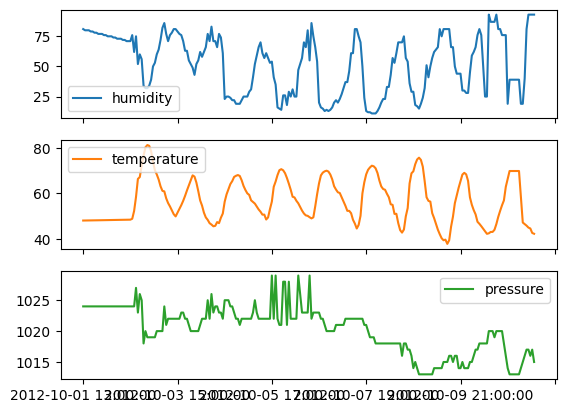

In [38]:
plot_cols = ["humidity", "temperature", "pressure"]


plot_features = portland[plot_cols][:240]
plot_features.index = datetime[:240]
_ = plot_features.plot(subplots=True)

In [39]:
portland.describe()

,humidity,pressure,temperature,wind_direction,wind_speed,encoded_description
count,45252.000000,45252.000000,45252.000000,45252.000000,45252.000000,45252.000000
mean,74.671462,1019.268187,53.317299,189.900071,2.050738,2.784496
std,19.058088,9.942836,13.414404,102.873761,1.840815,2.745342
min,10.000000,968.000000,12.600000,0.000000,0.000000,0.000000
25%,63.000000,1014.000000,44.060000,107.000000,1.000000,0.000000
50%,80.000000,1019.000000,52.110000,198.000000,1.000000,2.000000
75%,90.000000,1025.000000,61.342500,289.000000,3.000000,5.000000
max,100.000000,1056.000000,102.870000,360.000000,17.000000,23.000000


### converting wind speed and wind direction to wind vector

In [40]:
wind_speed = portland.pop("wind_speed")
wind_direction = portland.pop("wind_direction")

# convert to radians
wind_radians = wind_direction * np.pi / 180

# calculate wind x and y components
portland["windX"] = wind_speed * np.cos(wind_radians)
portland["windY"] = wind_speed * np.sin(wind_radians)

portland

,humidity,pressure,temperature,description,date_time,encoded_description,windX,windY
1,81.0,1024.0,48.07,scattered clouds,2012-10-01 13:00:00,6.0,0.000000,0.000000
2,80.0,1024.0,48.08,scattered clouds,2012-10-01 14:00:00,6.0,0.000000,0.000000
3,80.0,1024.0,48.10,scattered clouds,2012-10-01 15:00:00,6.0,0.000000,0.000000
4,80.0,1024.0,48.11,scattered clouds,2012-10-01 16:00:00,6.0,0.000000,0.000000
5,79.0,1024.0,48.13,scattered clouds,2012-10-01 17:00:00,6.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
45248,81.0,1031.0,47.93,broken clouds,2017-11-29 20:00:00,3.0,1.285575,1.532089
45249,71.0,1030.0,49.53,broken clouds,2017-11-29 21:00:00,3.0,0.866025,-0.500000
45250,71.0,1030.0,50.43,broken clouds,2017-11-29 22:00:00,3.0,0.342020,-0.939693
45251,71.0,1029.0,49.77,broken clouds,2017-11-29 23:00:00,3.0,0.684040,-1.879385


### converting time

In [41]:
date_time = pd.to_datetime(portland["date_time"], format='%Y-%m-%d %H:%M:%S')

timestamp_s = date_time.map(pd.Timestamp.timestamp)

timestamp_s[:10], timestamp_s[-10:]

(1     1.349096e+09
 2     1.349100e+09
 3     1.349104e+09
 4     1.349107e+09
 5     1.349111e+09
 6     1.349114e+09
 7     1.349118e+09
 8     1.349122e+09
 9     1.349125e+09
 10    1.349129e+09
 Name: date_time, dtype: float64,
 45243    1.511968e+09
 45244    1.511971e+09
 45245    1.511975e+09
 45246    1.511978e+09
 45247    1.511982e+09
 45248    1.511986e+09
 45249    1.511989e+09
 45250    1.511993e+09
 45251    1.511996e+09
 45252    1.512000e+09
 Name: date_time, dtype: float64)

In [42]:
day = 24*60*60
year = (365.2425)*day

portland['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
portland['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
portland['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
portland['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

portland

,humidity,pressure,temperature,description,date_time,encoded_description,windX,windY,Day sin,Day cos,Year sin,Year cos
1,81.0,1024.0,48.07,scattered clouds,2012-10-01 13:00:00,6.0,0.000000,0.000000,-2.588190e-01,-0.965926,-0.999973,0.007308
2,80.0,1024.0,48.08,scattered clouds,2012-10-01 14:00:00,6.0,0.000000,0.000000,-5.000000e-01,-0.866025,-0.999968,0.008024
3,80.0,1024.0,48.10,scattered clouds,2012-10-01 15:00:00,6.0,0.000000,0.000000,-7.071068e-01,-0.707107,-0.999962,0.008741
4,80.0,1024.0,48.11,scattered clouds,2012-10-01 16:00:00,6.0,0.000000,0.000000,-8.660254e-01,-0.500000,-0.999955,0.009458
5,79.0,1024.0,48.13,scattered clouds,2012-10-01 17:00:00,6.0,0.000000,0.000000,-9.659258e-01,-0.258819,-0.999948,0.010175
...,...,...,...,...,...,...,...,...,...,...,...,...
45248,81.0,1031.0,47.93,broken clouds,2017-11-29 20:00:00,3.0,1.285575,1.532089,-8.660254e-01,0.500000,-0.520267,0.854004
45249,71.0,1030.0,49.53,broken clouds,2017-11-29 21:00:00,3.0,0.866025,-0.500000,-7.071068e-01,0.707107,-0.519654,0.854377
45250,71.0,1030.0,50.43,broken clouds,2017-11-29 22:00:00,3.0,0.342020,-0.939693,-5.000000e-01,0.866025,-0.519042,0.854749
45251,71.0,1029.0,49.77,broken clouds,2017-11-29 23:00:00,3.0,0.684040,-1.879385,-2.588190e-01,0.965926,-0.518429,0.855121


Text(0.5, 1.0, 'Time of day signal')

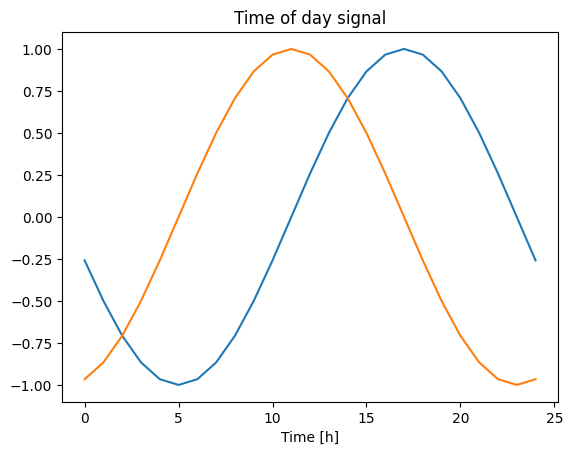

In [43]:
plt.plot(np.array(portland['Day sin'])[:25])
plt.plot(np.array(portland['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

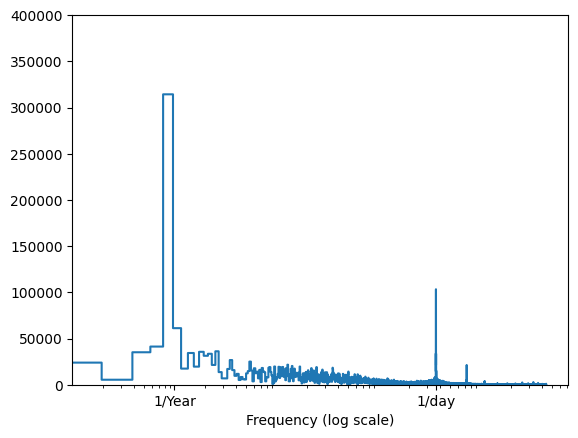

In [44]:
fft = tf.signal.rfft(portland['temperature'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(portland['temperature'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### train  test split and normalization

In [45]:
portland = portland.drop(["description", "date_time"], axis=1)

portland

,humidity,pressure,temperature,encoded_description,windX,windY,Day sin,Day cos,Year sin,Year cos
1,81.0,1024.0,48.07,6.0,0.000000,0.000000,-2.588190e-01,-0.965926,-0.999973,0.007308
2,80.0,1024.0,48.08,6.0,0.000000,0.000000,-5.000000e-01,-0.866025,-0.999968,0.008024
3,80.0,1024.0,48.10,6.0,0.000000,0.000000,-7.071068e-01,-0.707107,-0.999962,0.008741
4,80.0,1024.0,48.11,6.0,0.000000,0.000000,-8.660254e-01,-0.500000,-0.999955,0.009458
5,79.0,1024.0,48.13,6.0,0.000000,0.000000,-9.659258e-01,-0.258819,-0.999948,0.010175
...,...,...,...,...,...,...,...,...,...,...
45248,81.0,1031.0,47.93,3.0,1.285575,1.532089,-8.660254e-01,0.500000,-0.520267,0.854004
45249,71.0,1030.0,49.53,3.0,0.866025,-0.500000,-7.071068e-01,0.707107,-0.519654,0.854377
45250,71.0,1030.0,50.43,3.0,0.342020,-0.939693,-5.000000e-01,0.866025,-0.519042,0.854749
45251,71.0,1029.0,49.77,3.0,0.684040,-1.879385,-2.588190e-01,0.965926,-0.518429,0.855121


In [46]:
n = len(portland)
train_portland = portland[0:int(n*0.7)]
val_portland = portland[int(n*0.7):int(n*0.9)]
test_portland = portland[int(n*0.9):]

per TF tutorial:

The mean and standard deviation should be computed using <b>only the training data</b> so that the models have no access to the values in the validation and test sets.

In [47]:
train_mean = train_portland.mean()
train_std = train_portland.std()

train_df = (train_portland - train_mean) / train_std
val_df = (val_portland - train_mean) / train_std
test_df = (test_portland - train_mean) / train_std

In [48]:
train_df

,humidity,pressure,temperature,encoded_description,windX,windY,Day sin,Day cos,Year sin,Year cos
1,0.301326,0.302795,-0.324748,1.233692,0.194131,0.000921,-0.365941,-1.366213,-1.441480,-0.100446
2,0.247968,0.302795,-0.323987,1.233692,0.194131,0.000921,-0.707004,-1.224929,-1.441472,-0.099415
3,0.247968,0.302795,-0.322467,1.233692,0.194131,0.000921,-0.999881,-1.000180,-1.441464,-0.098384
4,0.247968,0.302795,-0.321707,1.233692,0.194131,0.000921,-1.224614,-0.707280,-1.441454,-0.097353
5,0.194610,0.302795,-0.320186,1.233692,0.194131,0.000921,-1.365887,-0.366191,-1.441445,-0.096322
...,...,...,...,...,...,...,...,...,...,...
31672,-1.726270,-0.655656,1.055015,0.860657,1.983794,-1.288251,1.224745,0.706964,1.014117,-1.056599
31673,-1.459481,-0.655656,0.817833,0.860657,1.695837,-1.535454,1.366018,0.365875,1.013457,-1.057376
31674,-1.779628,-0.655656,0.659711,0.860657,1.205752,-0.500478,1.414204,-0.000158,1.012797,-1.058152
31675,-1.459481,-0.655656,0.447615,-1.004520,1.362251,0.000921,1.366018,-0.366191,1.012135,-1.058928


### plot distribution of features

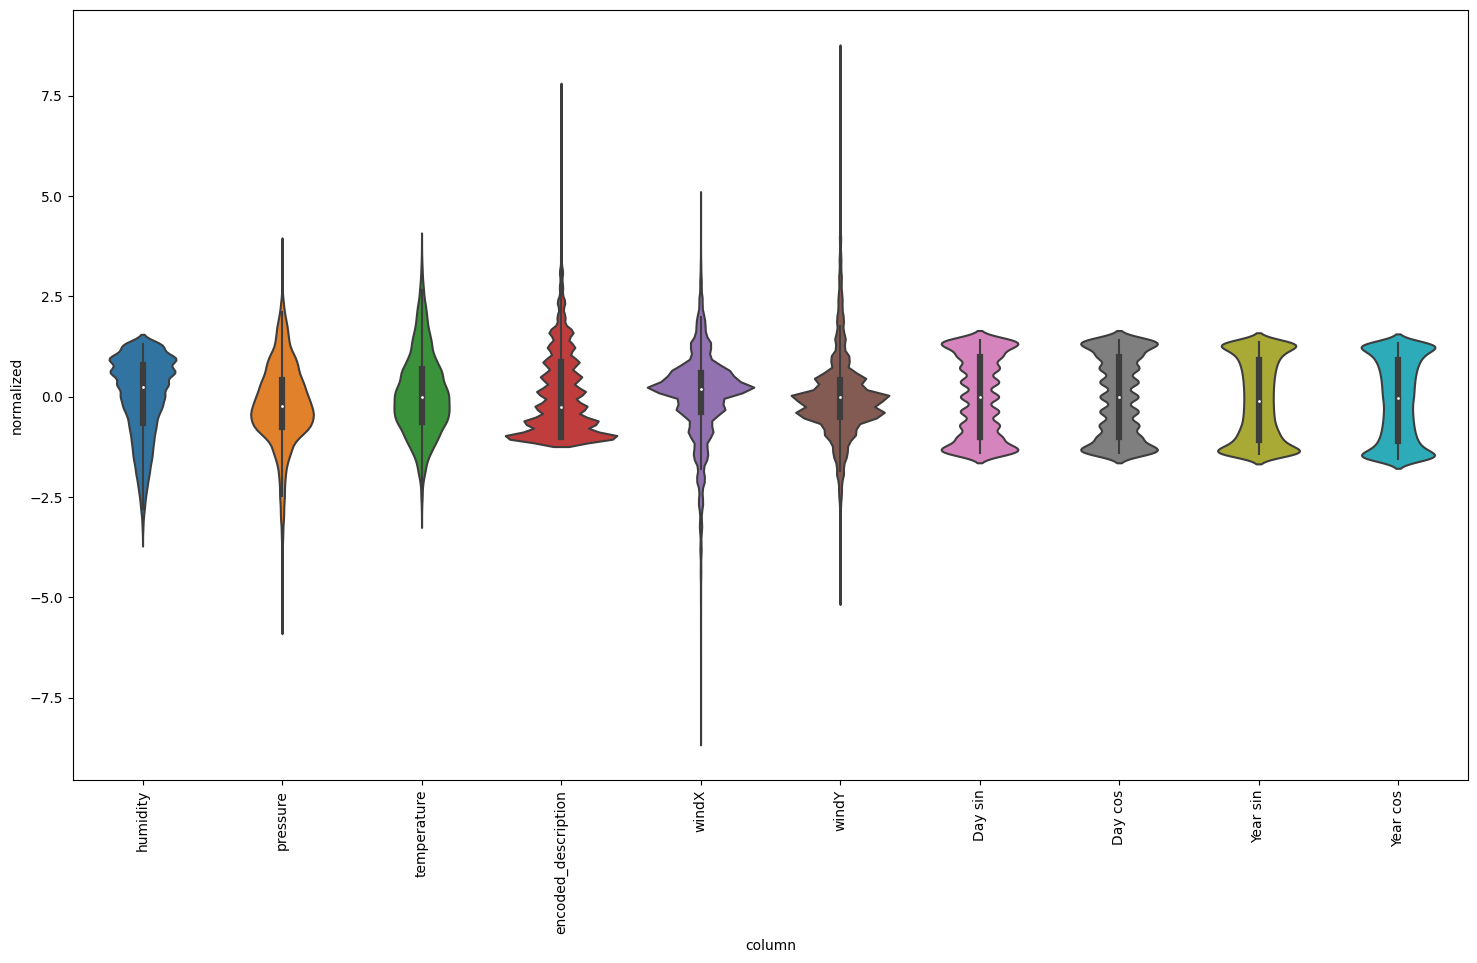

In [49]:
portland_std = (portland - train_mean) / train_std
portland_std = portland_std.melt(var_name="column", value_name="normalized")

plt.figure(figsize=(18, 10))
ax = sns.violinplot(x="column", y="normalized", data=portland_std)
_ = ax.set_xticklabels(portland.keys(), rotation=90)

In [50]:
column_indices = {name: i for i, name in enumerate(portland.columns)}

column_indices

{'humidity': 0,
 'pressure': 1,
 'temperature': 2,
 'encoded_description': 3,
 'windX': 4,
 'windY': 5,
 'Day sin': 6,
 'Day cos': 7,
 'Year sin': 8,
 'Year cos': 9}

## Data Windowing 🪟

In [51]:
# create WindowGenerator() class

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df,
               val_df=val_df,
               test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

let's generate some windows to make sure it works

In [52]:
sample_window = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=["temperature"])

sample_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['temperature']

In [53]:
another_sample_window = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=["temperature"])

another_sample_window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['temperature']

In [54]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [55]:
# Stack three slices, the length of the total window.
third_example_window = tf.stack([np.array(train_df[:another_sample_window.total_window_size]),
                           np.array(train_df[100:100+another_sample_window.total_window_size]),
                           np.array(train_df[200:200+another_sample_window.total_window_size])])

example_inputs, example_labels = another_sample_window.split_window(third_example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {third_example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 10)
Inputs shape: (3, 6, 10)
Labels shape: (3, 1, 1)


makes sense! the entire window is a size of 7.

6 from the inputs and 1 from the label.

there are 10 features in the window, but only 1 in the label.

In [56]:
another_sample_window.example = example_inputs, example_labels

In [57]:
def plot(self, model=None, plot_col="temperature", max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel("time (hours)")

WindowGenerator.plot = plot

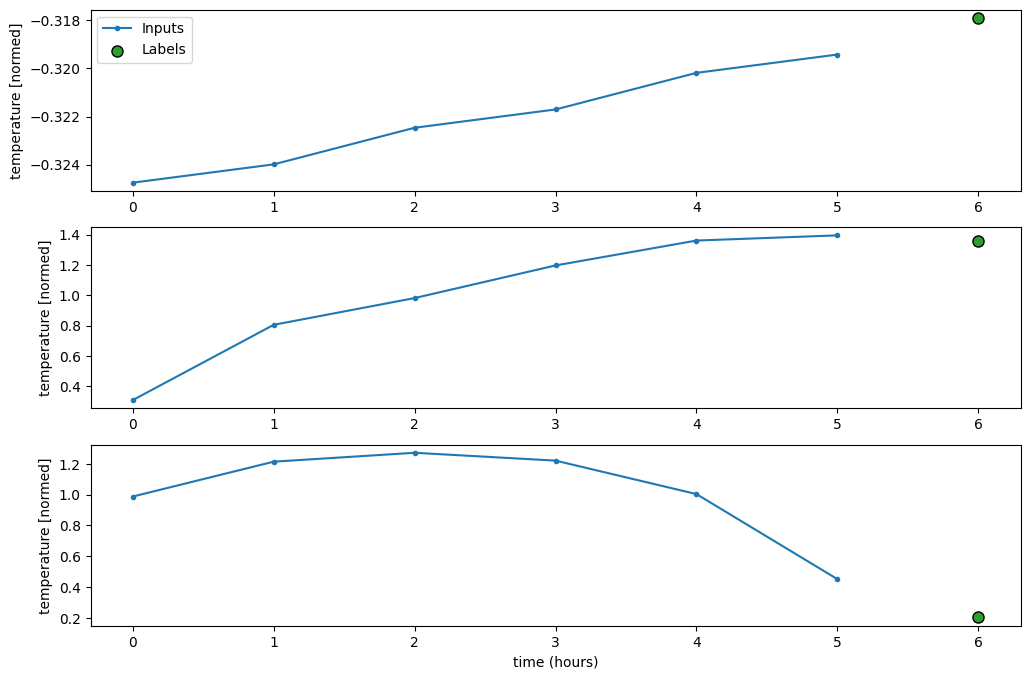

In [58]:
another_sample_window.plot()

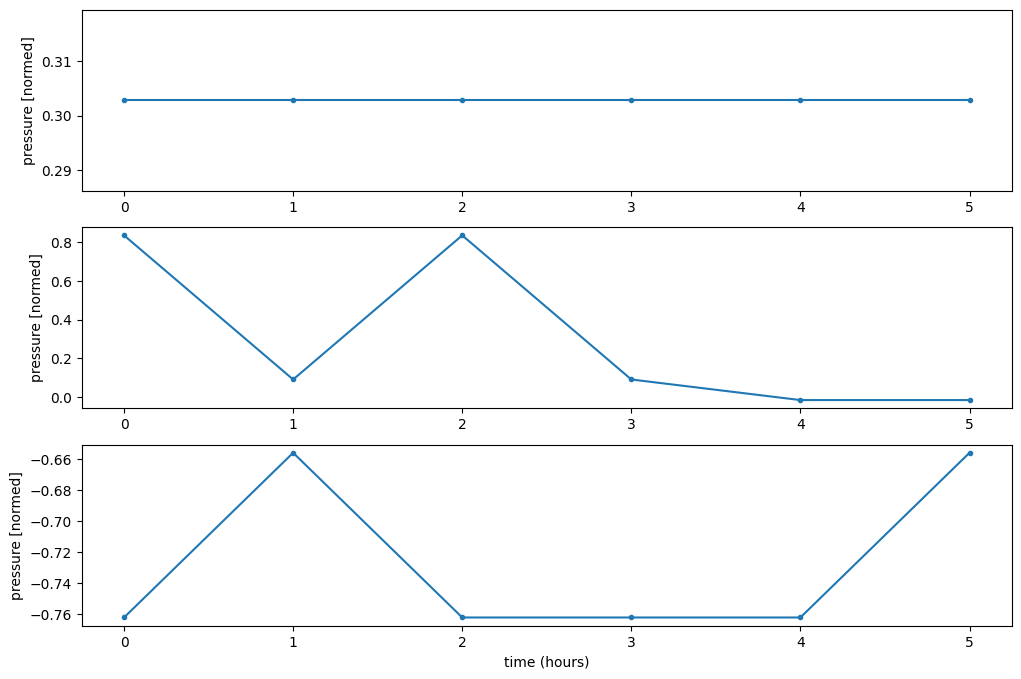

In [59]:
another_sample_window.plot(plot_col="pressure")

<font size=8>🤔</font>

 why is our pressure plot missing labels?

 when we make our sample window, we used our `temperature` column. let's make some additional windows using the other columns.

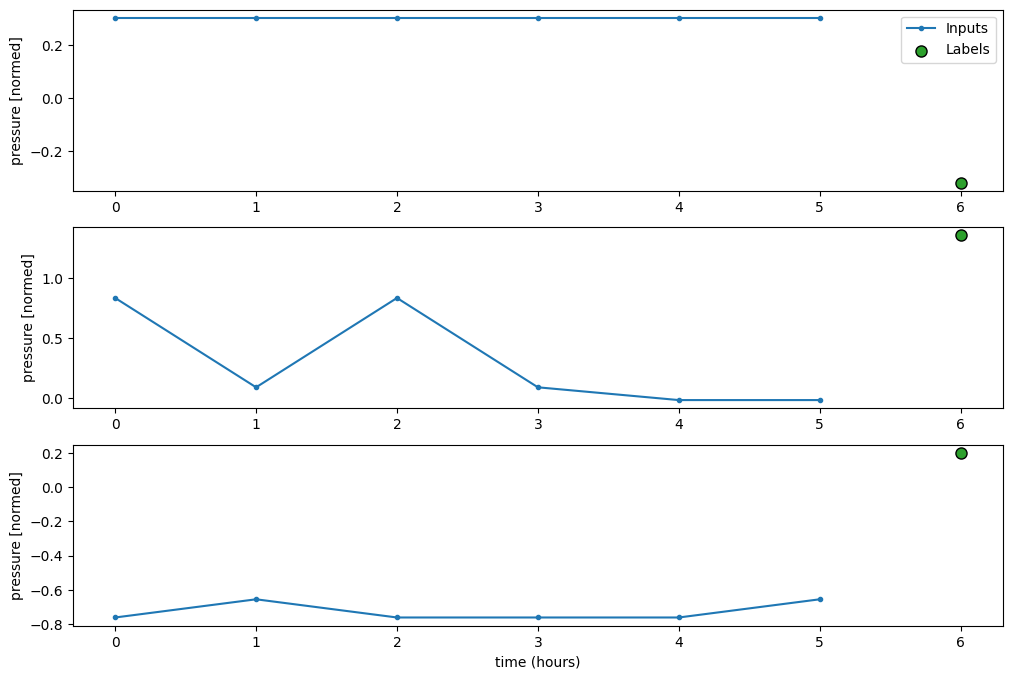

In [60]:
sample_pressure_window = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=["pressure"])
sample_pressure_window.example = example_inputs, example_labels

sample_pressure_window.plot(plot_col="pressure")

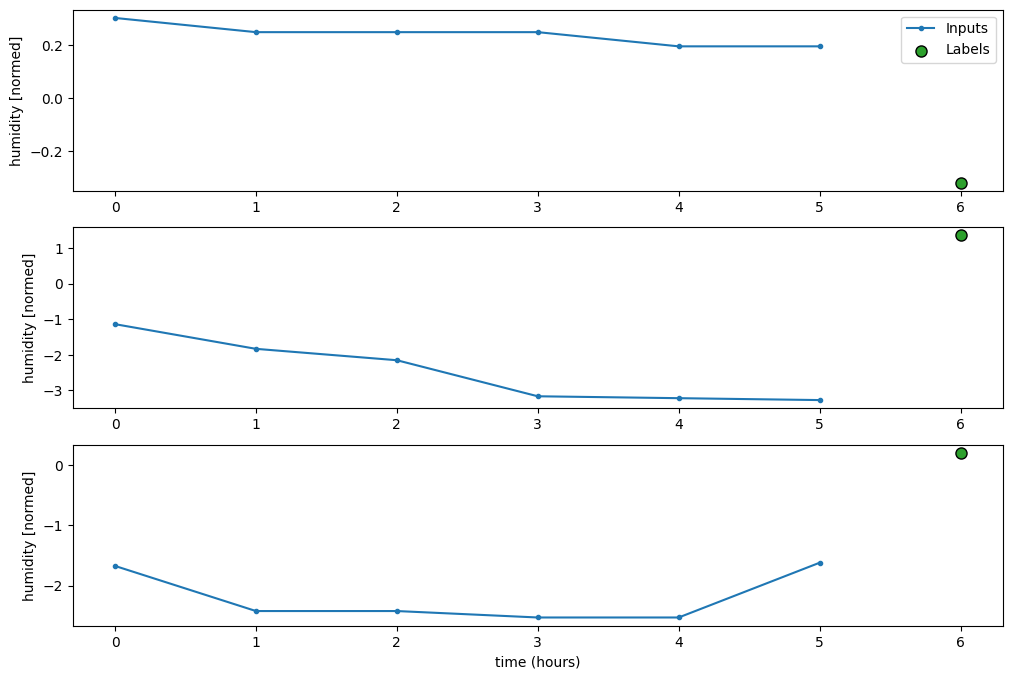

In [61]:
sample_humidity_window = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=["humidity"])
sample_humidity_window.example = example_inputs, example_labels

sample_humidity_window.plot(plot_col="humidity")

that looks better!

### creating `tf.data.Datasets`

In [62]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [63]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [64]:
# Each element is an (inputs, label) pair.

another_sample_window.train.element_spec

(TensorSpec(shape=(None, 6, 10), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

## Single Step Models

we'll get started by making a model that can predict one feature (temp, pressure, etc) one step (one hour in this case) into the "future".

In [65]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=["temperature"])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['temperature']

In [66]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 10)
Labels shape (batch, time, features): (32, 1, 1)


### baseline

In [67]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [68]:
baseline = Baseline(label_index=column_indices["temperature"])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test)

142/142 [==============================] - 1s 4ms/step - loss: 0.0321 - mean_absolute_error: 0.1354


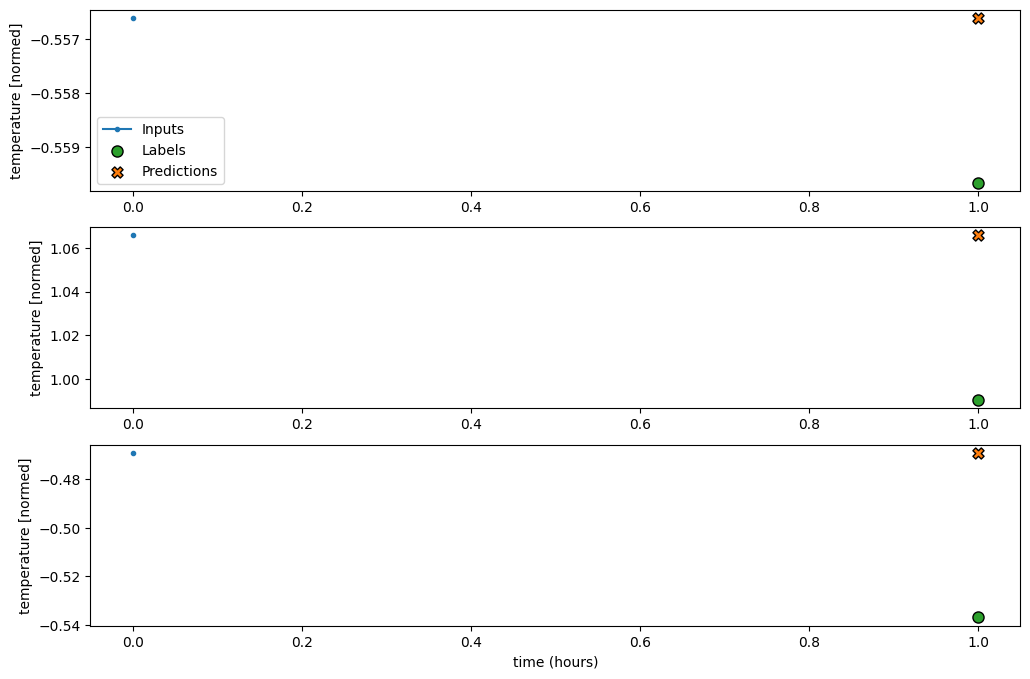

In [69]:
single_step_window.plot(baseline)

not super interesting.

let's make a wider window.

In [70]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=["temperature"])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['temperature']

In [71]:
print("input shape:", wide_window.example[0].shape)
print("output shape:", baseline(wide_window.example[0]).shape)

input shape: (32, 24, 10)
output shape: (32, 24, 1)


let's take a look at a window:

In [72]:
wide_window.example[0]

<tf.Tensor: shape=(32, 24, 10), dtype=float32, numpy=
array([[[ 9.4161940e-01, -7.6215070e-01,  2.0815244e-01, ...,
          1.2246133e+00, -1.2731359e+00,  5.7289958e-01],
        [ 6.2147266e-01, -8.6864525e-01,  1.9826986e-01, ...,
          1.3658968e+00, -1.2726585e+00,  5.7380646e-01],
        [ 1.3151239e+00, -8.6864525e-01,  1.9826986e-01, ...,
          1.4140861e+00, -1.2721803e+00,  5.7471299e-01],
        ...,
        [ 3.5468373e-01, -3.3617255e-01,  7.0076185e-01, ...,
          3.6587530e-01, -1.2629753e+00,  5.9186995e-01],
        [-1.7889412e-01, -3.3617255e-01,  8.0186844e-01, ...,
          7.0696402e-01, -1.2624846e+00,  5.9276938e-01],
        [-3.9232528e-01, -4.4266710e-01,  8.2619482e-01, ...,
          9.9986356e-01, -1.2619932e+00,  5.9366846e-01]],

       [[-7.2178550e-02, -7.6215070e-01,  6.4222646e-01, ...,
         -1.5800896e-04,  3.7596062e-01,  1.2622021e+00],
        [-7.2178550e-02, -7.6215070e-01,  6.4222646e-01, ...,
         -3.6619130e-01,  3.7

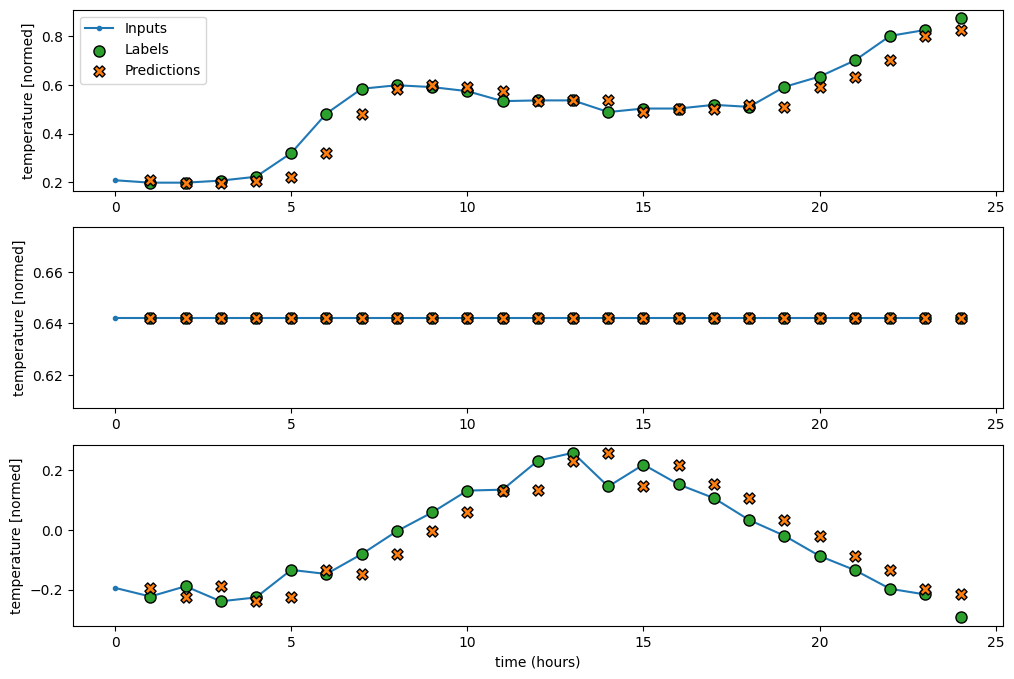

In [73]:
# plot

wide_window.plot(baseline)

### linear model

In [74]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

In [75]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=["temperature"])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['temperature']

In [76]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 10)
Output shape: (32, 1, 1)


#### `compile_and_fit()` function

In [77]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train,
                      epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [78]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test)

Epoch 1/20
990/990 [==============================] - 9s 7ms/step - loss: 0.8995 - mean_absolute_error: 0.6784 - val_loss: 0.1220 - val_mean_absolute_error: 0.2681
Epoch 2/20
990/990 [==============================] - 7s 7ms/step - loss: 0.0604 - mean_absolute_error: 0.1864 - val_loss: 0.0309 - val_mean_absolute_error: 0.1395
Epoch 3/20
990/990 [==============================] - 7s 7ms/step - loss: 0.0291 - mean_absolute_error: 0.1259 - val_loss: 0.0166 - val_mean_absolute_error: 0.0991
Epoch 4/20
990/990 [==============================] - 8s 7ms/step - loss: 0.0225 - mean_absolute_error: 0.1044 - val_loss: 0.0134 - val_mean_absolute_error: 0.0872
Epoch 5/20
990/990 [==============================] - 7s 7ms/step - loss: 0.0216 - mean_absolute_error: 0.0999 - val_loss: 0.0131 - val_mean_absolute_error: 0.0859
Epoch 6/20
990/990 [==============================] - 6s 6ms/step - loss: 0.0215 - mean_absolute_error: 0.0995 - val_loss: 0.0132 - val_mean_absolute_error: 0.0864
Epoch 7/20
990/9

In [79]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 10)
Output shape: (32, 24, 1)


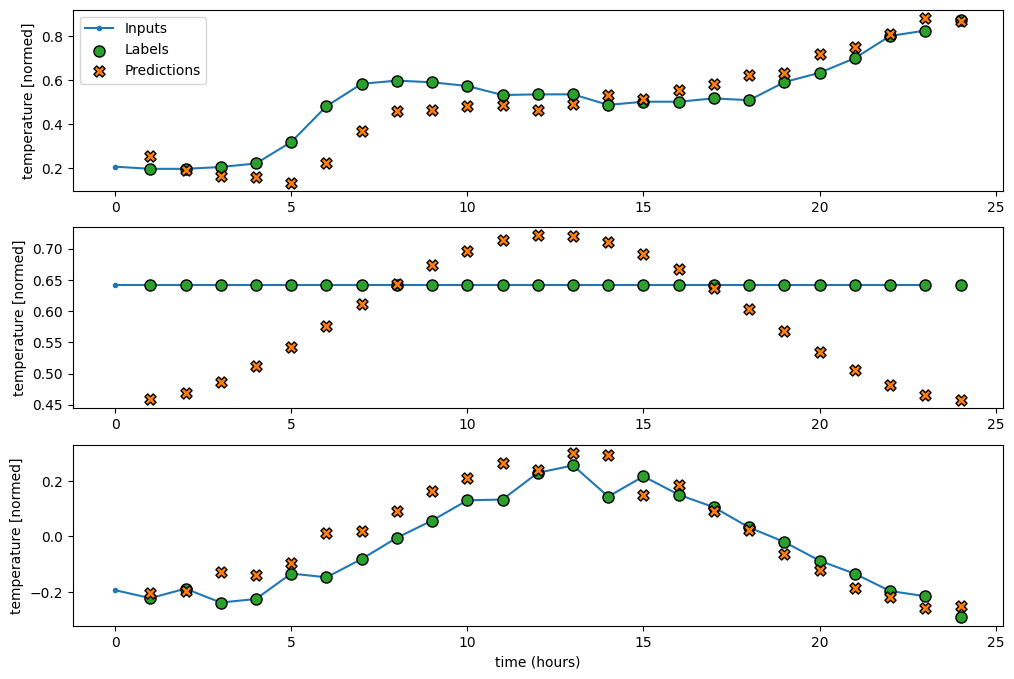

In [80]:
wide_window.plot(linear)

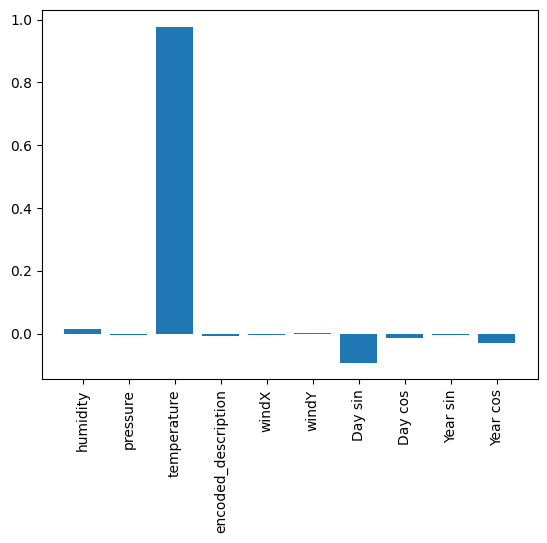

In [81]:
# pull out the layer's weights and visualize the weight assigned to each input:

plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### dense model

In [82]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

Epoch 1/20
990/990 [==============================] - 11s 10ms/step - loss: 0.0380 - mean_absolute_error: 0.1221 - val_loss: 0.0132 - val_mean_absolute_error: 0.0867
Epoch 2/20
990/990 [==============================] - 7s 8ms/step - loss: 0.0201 - mean_absolute_error: 0.0952 - val_loss: 0.0117 - val_mean_absolute_error: 0.0800
Epoch 3/20
990/990 [==============================] - 8s 8ms/step - loss: 0.0192 - mean_absolute_error: 0.0923 - val_loss: 0.0117 - val_mean_absolute_error: 0.0804
Epoch 4/20
990/990 [==============================] - 8s 9ms/step - loss: 0.0187 - mean_absolute_error: 0.0906 - val_loss: 0.0110 - val_mean_absolute_error: 0.0770
Epoch 5/20
990/990 [==============================] - 8s 8ms/step - loss: 0.0184 - mean_absolute_error: 0.0893 - val_loss: 0.0108 - val_mean_absolute_error: 0.0759
Epoch 6/20
990/990 [==============================] - 11s 11ms/step - loss: 0.0181 - mean_absolute_error: 0.0885 - val_loss: 0.0114 - val_mean_absolute_error: 0.0789
Epoch 7/20
9

In [83]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=["temperature"])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['temperature']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

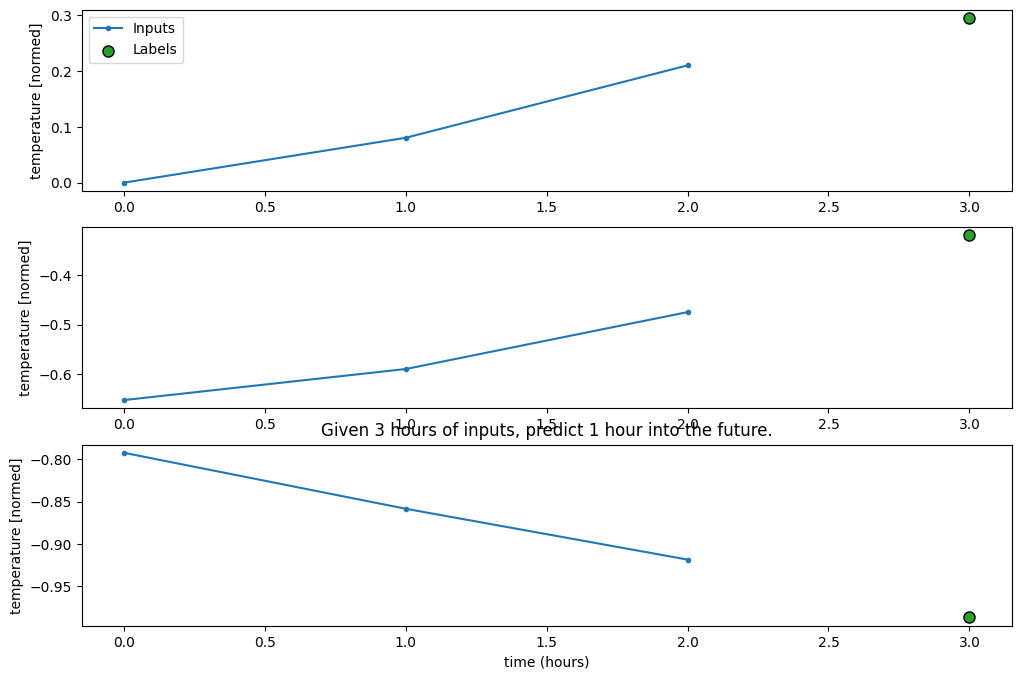

In [84]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [85]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [86]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 10)
Output shape: (32, 1, 1)


In [87]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test)

Epoch 1/20
990/990 [==============================] - 11s 8ms/step - loss: 0.0827 - mean_absolute_error: 0.1808 - val_loss: 0.0223 - val_mean_absolute_error: 0.1138
Epoch 2/20
990/990 [==============================] - 7s 7ms/step - loss: 0.0236 - mean_absolute_error: 0.1080 - val_loss: 0.0173 - val_mean_absolute_error: 0.0985
Epoch 3/20
990/990 [==============================] - 7s 7ms/step - loss: 0.0207 - mean_absolute_error: 0.0990 - val_loss: 0.0149 - val_mean_absolute_error: 0.0907
Epoch 4/20
990/990 [==============================] - 8s 8ms/step - loss: 0.0193 - mean_absolute_error: 0.0947 - val_loss: 0.0133 - val_mean_absolute_error: 0.0844
Epoch 5/20
990/990 [==============================] - 6s 6ms/step - loss: 0.0186 - mean_absolute_error: 0.0920 - val_loss: 0.0134 - val_mean_absolute_error: 0.0852
Epoch 6/20
990/990 [==============================] - 8s 8ms/step - loss: 0.0180 - mean_absolute_error: 0.0897 - val_loss: 0.0118 - val_mean_absolute_error: 0.0786
Epoch 7/20
990/

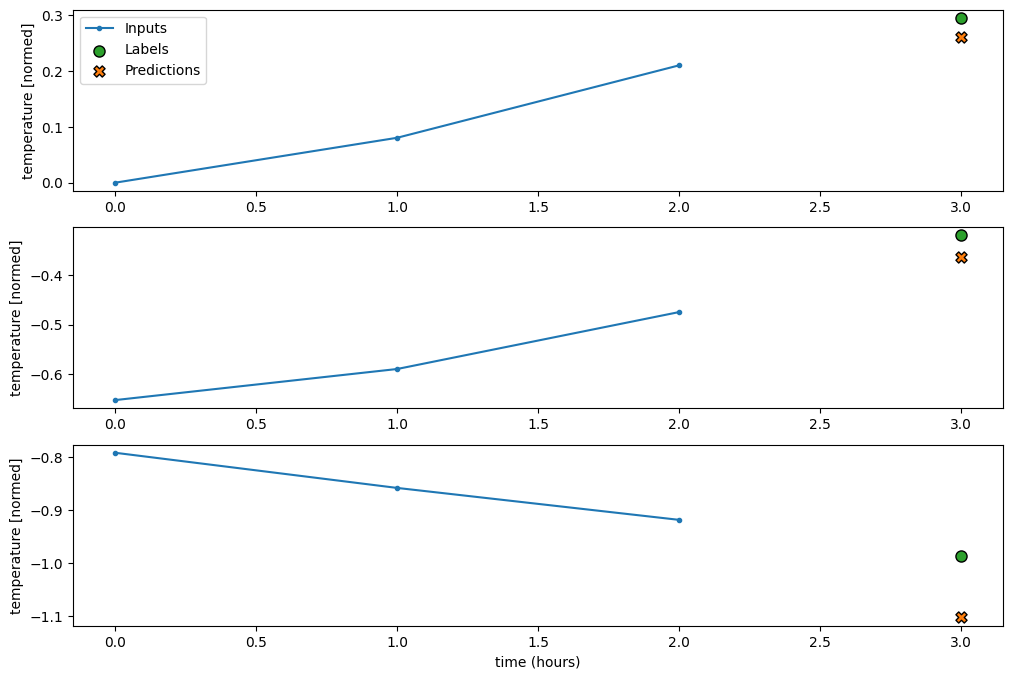

In [88]:
conv_window.plot(multi_step_dense)

In [89]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 10)

ValueError:Exception encountered when calling layer 'sequential_2' (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 30, but received input with shape (32, 240)

Call arguments received by layer 'sequential_2' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 10), dtype=float32)
  • training=None
  • mask=None


⬆️ we need a conv1D model to address this error.

### conv1D model

In [98]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [91]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 10)
Output shape: (32, 1, 1)


In [92]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv1D'] = conv_model.evaluate(conv_window.val)
performance['Conv1D'] = conv_model.evaluate(conv_window.test)

Epoch 1/20
990/990 [==============================] - 15s 9ms/step - loss: 0.0429 - mean_absolute_error: 0.1421 - val_loss: 0.0185 - val_mean_absolute_error: 0.1028
Epoch 2/20
990/990 [==============================] - 8s 8ms/step - loss: 0.0217 - mean_absolute_error: 0.1023 - val_loss: 0.0142 - val_mean_absolute_error: 0.0886
Epoch 3/20
990/990 [==============================] - 9s 9ms/step - loss: 0.0198 - mean_absolute_error: 0.0961 - val_loss: 0.0125 - val_mean_absolute_error: 0.0821
Epoch 4/20
990/990 [==============================] - 9s 9ms/step - loss: 0.0189 - mean_absolute_error: 0.0930 - val_loss: 0.0117 - val_mean_absolute_error: 0.0784
Epoch 5/20
990/990 [==============================] - 8s 8ms/step - loss: 0.0184 - mean_absolute_error: 0.0914 - val_loss: 0.0125 - val_mean_absolute_error: 0.0825
Epoch 6/20
990/990 [==============================] - 8s 8ms/step - loss: 0.0181 - mean_absolute_error: 0.0899 - val_loss: 0.0112 - val_mean_absolute_error: 0.0759
Epoch 7/20
990/

In [93]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 10)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [94]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=["temperature"])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['temperature']

In [95]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 10)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


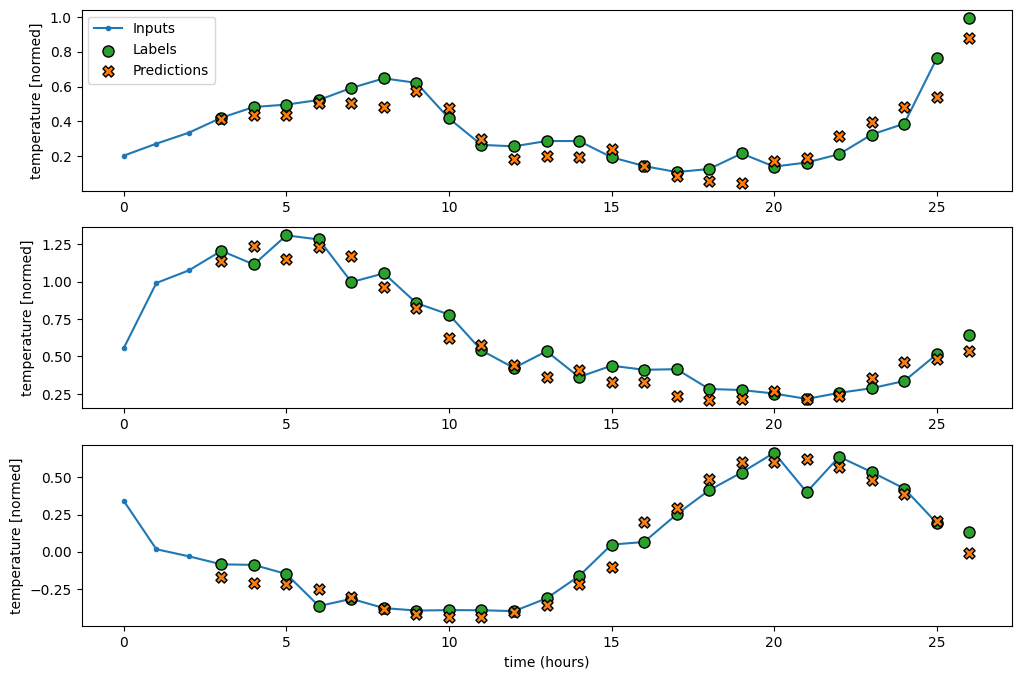

In [96]:
wide_conv_window.plot(conv_model)

In [106]:
conv_model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

history = compile_and_fit(conv_model_2, conv_window)

val_performance['Conv1D (with Dropout and Flatten)'] = conv_model_2.evaluate(conv_window.val)
performance['Conv1D (with Dropout and Flatten)'] = conv_model_2.evaluate(conv_window.test)

Epoch 1/20
990/990 [==============================] - 10s 9ms/step - loss: 0.0958 - mean_absolute_error: 0.2196 - val_loss: 0.0287 - val_mean_absolute_error: 0.1282
Epoch 2/20
990/990 [==============================] - 7s 7ms/step - loss: 0.0365 - mean_absolute_error: 0.1389 - val_loss: 0.0359 - val_mean_absolute_error: 0.1415
Epoch 3/20
990/990 [==============================] - 7s 7ms/step - loss: 0.0290 - mean_absolute_error: 0.1215 - val_loss: 0.0491 - val_mean_absolute_error: 0.1655
Epoch 4/20
142/142 [==============================] - 1s 4ms/step - loss: 0.0715 - mean_absolute_error: 0.2020


### RNN (lstm) model

In [107]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [108]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 10)
Output shape: (32, 24, 1)


In [109]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test)

Epoch 1/20
990/990 [==============================] - 14s 10ms/step - loss: 0.0505 - mean_absolute_error: 0.1417 - val_loss: 0.0140 - val_mean_absolute_error: 0.0850
Epoch 2/20
990/990 [==============================] - 11s 12ms/step - loss: 0.0176 - mean_absolute_error: 0.0857 - val_loss: 0.0107 - val_mean_absolute_error: 0.0737
Epoch 3/20
990/990 [==============================] - 10s 10ms/step - loss: 0.0161 - mean_absolute_error: 0.0808 - val_loss: 0.0112 - val_mean_absolute_error: 0.0758
Epoch 4/20
990/990 [==============================] - 10s 10ms/step - loss: 0.0153 - mean_absolute_error: 0.0789 - val_loss: 0.0105 - val_mean_absolute_error: 0.0730
Epoch 5/20
990/990 [==============================] - 10s 10ms/step - loss: 0.0148 - mean_absolute_error: 0.0775 - val_loss: 0.0103 - val_mean_absolute_error: 0.0726
Epoch 6/20
990/990 [==============================] - 10s 10ms/step - loss: 0.0143 - mean_absolute_error: 0.0766 - val_loss: 0.0102 - val_mean_absolute_error: 0.0718
Epoc

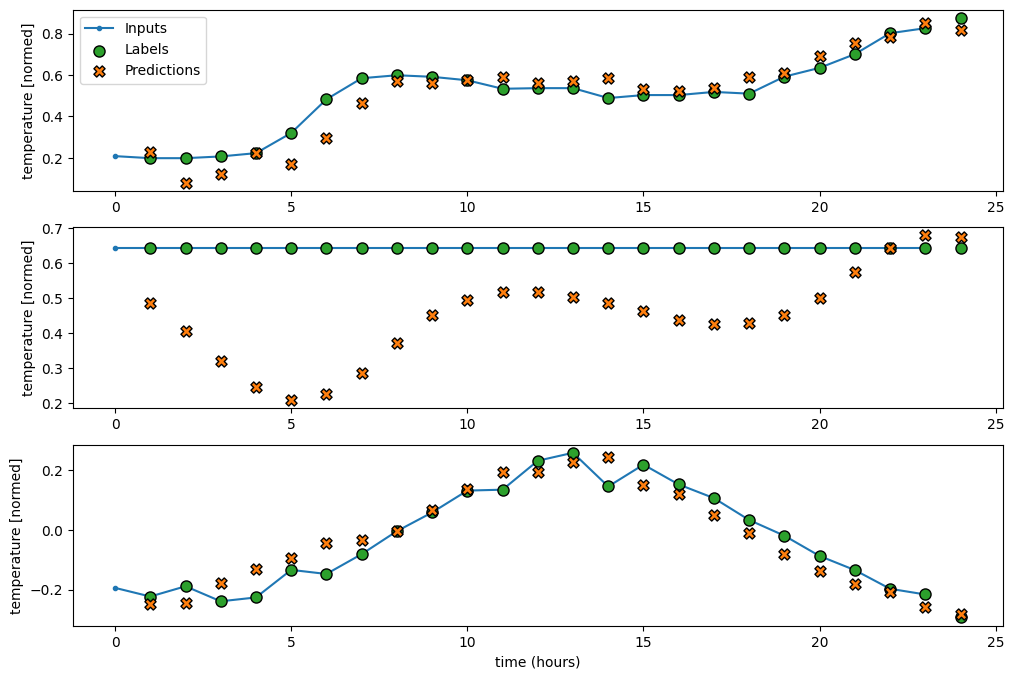

In [110]:
wide_window.plot(lstm_model)

In [111]:
lstm_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model_2, wide_window)

val_performance['LSTM (2 layers)'] = lstm_model_2.evaluate(wide_window.val)
performance['LSTM (2 layers)'] = lstm_model_2.evaluate(wide_window.test)

Epoch 1/20
990/990 [==============================] - 16s 12ms/step - loss: 0.2282 - mean_absolute_error: 0.3638 - val_loss: 0.2099 - val_mean_absolute_error: 0.3423
Epoch 2/20
990/990 [==============================] - 12s 12ms/step - loss: 0.2155 - mean_absolute_error: 0.3535 - val_loss: 0.2082 - val_mean_absolute_error: 0.3407
Epoch 3/20
990/990 [==============================] - 11s 11ms/step - loss: 0.2152 - mean_absolute_error: 0.3532 - val_loss: 0.2079 - val_mean_absolute_error: 0.3402
Epoch 4/20
990/990 [==============================] - 11s 12ms/step - loss: 0.2151 - mean_absolute_error: 0.3531 - val_loss: 0.2075 - val_mean_absolute_error: 0.3394
Epoch 5/20
990/990 [==============================] - 12s 12ms/step - loss: 0.2150 - mean_absolute_error: 0.3530 - val_loss: 0.2076 - val_mean_absolute_error: 0.3396
Epoch 6/20
990/990 [==============================] - 11s 11ms/step - loss: 0.2149 - mean_absolute_error: 0.3529 - val_loss: 0.2084 - val_mean_absolute_error: 0.3415
Epoc

### comparing single step models

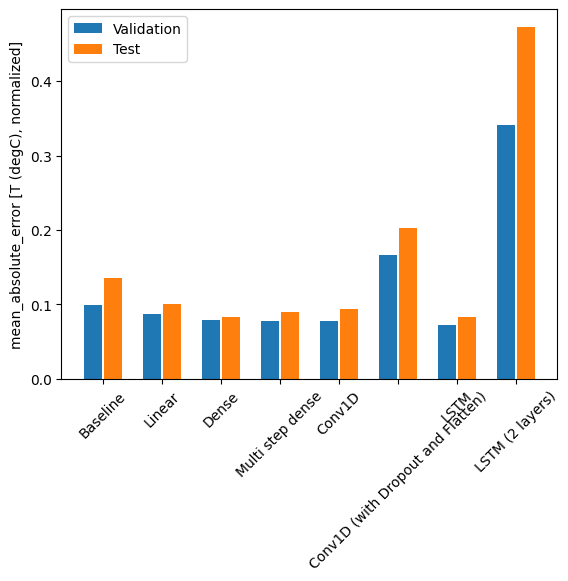

In [112]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [114]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.1354
Linear      : 0.0999
Dense       : 0.0824
Multi step dense: 0.0891
Conv1D      : 0.0938
Conv1D (with Dropout and Flatten): 0.2020
LSTM        : 0.0828
LSTM (2 layers): 0.4730


### ensemble model

In [117]:
def get_ensemble_models(window,
                        num_iter=10,
                        num_epochs=30,
                        loss_fns=["mae", "mse"]):
  """
  returns a list of num_iter models each train on MAE and MSE loss.
  example: if num_iter=10, a list of 20 trained models will be returned (10 * 2).
  """

  train_data = window.train
  val_data = window.val
  test_data = window.test
  # make empty list of trained ensemble models
  ensemble_models = []

  # create num_iter number of models per loss function
  for i in range(num_iter):
    # build and fit a new model with a DIFFERENT loss function
    for loss_function in loss_fns:
      print(f"optimizing model by reducing {loss_function} for {num_epochs} epochs, model number: {i}")

      # construct simple model (similar to our dense model)
      model = tf.keras.Sequential([
          tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          tf.keras.layers.Dense(1) # output layer
      ])

      # compile model
      model.compile(loss=f"{loss_function}",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=val_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=8,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                               patience=5,
                                                               verbose=1)])

      # append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [118]:
ensemble_models = get_ensemble_models(window=wide_window)

optimizing model by reducing mae for 30 epochs, model number: 0

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
optimizing model by reducing mse for 30 epochs, model number: 0

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
optimizing model by reducing mae for 30 epochs, model number: 1

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 16: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
optimizing model by reducing mse for 30 epochs, model number: 1

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
optimizing model by reducing mae for 30 epochs, model number: 2

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 19: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
optimizing model by reducing mse for 30 epochs, model number: 2

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001000

In [119]:
for i in ensemble_models:
  val_performance[f"model {i}"] = i.evaluate(wide_window.val)
  performance[f"model {i}"] = i.evaluate(wide_window.test)

141/141 [==============================] - 1s 7ms/step - loss: 0.0152 - mae: 0.0906 - mse: 0.0152


In [120]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.1354
Linear      : 0.0999
Dense       : 0.0824
Multi step dense: 0.0891
Conv1D      : 0.0938
Conv1D (with Dropout and Flatten): 0.2020
LSTM        : 0.0828
LSTM (2 layers): 0.4730
model <keras.engine.sequential.Sequential object at 0x7af6a06a3f40>: 0.0791
model <keras.engine.sequential.Sequential object at 0x7af6a05d1810>: 0.0926
model <keras.engine.sequential.Sequential object at 0x7af6a03ee230>: 0.0794
model <keras.engine.sequential.Sequential object at 0x7af7379d54e0>: 0.0843
model <keras.engine.sequential.Sequential object at 0x7af6d4b52050>: 0.0829
model <keras.engine.sequential.Sequential object at 0x7af6967a3b50>: 0.0905
model <keras.engine.sequential.Sequential object at 0x7af69655a230>: 0.0766
model <keras.engine.sequential.Sequential object at 0x7af69645fbe0>: 0.0954
model <keras.engine.sequential.Sequential object at 0x7af6963288e0>: 0.0815
model <keras.engine.sequential.Sequential object at 0x7af6962d55d0>: 0.0893
model <keras.engine.sequential.Sequential ob

best mae is `ensemble_models[6]` at 0.0766!

### multi-output versions

predicting on all 10 features instead of just temperature.

In [121]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 10)
Labels shape (batch, time, features): (32, 24, 10)


#### baseline

In [122]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_output_val_performance = {}
multi_output_performance = {}
multi_output_val_performance['Baseline'] = baseline.evaluate(wide_window.val)
multi_output_performance['Baseline'] = baseline.evaluate(wide_window.test)

141/141 [==============================] - 1s 4ms/step - loss: 0.2219 - mean_absolute_error: 0.2372


#### dense model

In [123]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=10) # 10 features
])

history = compile_and_fit(dense, single_step_window)

multi_output_val_performance['Dense'] = dense.evaluate(single_step_window.val)
multi_output_performance['Dense'] = dense.evaluate(single_step_window.test)

Epoch 1/20
990/990 [==============================] - 10s 9ms/step - loss: 0.1987 - mean_absolute_error: 0.2583 - val_loss: 0.1906 - val_mean_absolute_error: 0.2343
Epoch 2/20
990/990 [==============================] - 9s 9ms/step - loss: 0.1556 - mean_absolute_error: 0.2037 - val_loss: 0.1894 - val_mean_absolute_error: 0.2308
Epoch 3/20
990/990 [==============================] - 9s 9ms/step - loss: 0.1534 - mean_absolute_error: 0.1983 - val_loss: 0.1893 - val_mean_absolute_error: 0.2275
Epoch 4/20
990/990 [==============================] - 8s 8ms/step - loss: 0.1521 - mean_absolute_error: 0.1952 - val_loss: 0.1874 - val_mean_absolute_error: 0.2252
Epoch 5/20
990/990 [==============================] - 9s 9ms/step - loss: 0.1512 - mean_absolute_error: 0.1934 - val_loss: 0.1839 - val_mean_absolute_error: 0.2187
Epoch 6/20
990/990 [==============================] - 11s 11ms/step - loss: 0.1506 - mean_absolute_error: 0.1918 - val_loss: 0.1837 - val_mean_absolute_error: 0.2170
Epoch 7/20
99

#### RNN

In [124]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=10)
])

history = compile_and_fit(lstm_model, wide_window)

multi_output_val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
multi_output_performance['LSTM'] = lstm_model.evaluate( wide_window.test)

Epoch 1/20
990/990 [==============================] - 16s 12ms/step - loss: 0.2360 - mean_absolute_error: 0.2954 - val_loss: 0.1866 - val_mean_absolute_error: 0.2368
Epoch 2/20
990/990 [==============================] - 9s 9ms/step - loss: 0.1467 - mean_absolute_error: 0.1957 - val_loss: 0.1756 - val_mean_absolute_error: 0.2187
Epoch 3/20
990/990 [==============================] - 9s 9ms/step - loss: 0.1415 - mean_absolute_error: 0.1857 - val_loss: 0.1724 - val_mean_absolute_error: 0.2122
Epoch 4/20
990/990 [==============================] - 9s 9ms/step - loss: 0.1393 - mean_absolute_error: 0.1813 - val_loss: 0.1710 - val_mean_absolute_error: 0.2093
Epoch 5/20
990/990 [==============================] - 9s 9ms/step - loss: 0.1380 - mean_absolute_error: 0.1790 - val_loss: 0.1710 - val_mean_absolute_error: 0.2080
Epoch 6/20
990/990 [==============================] - 9s 9ms/step - loss: 0.1371 - mean_absolute_error: 0.1777 - val_loss: 0.1707 - val_mean_absolute_error: 0.2069
Epoch 7/20
990

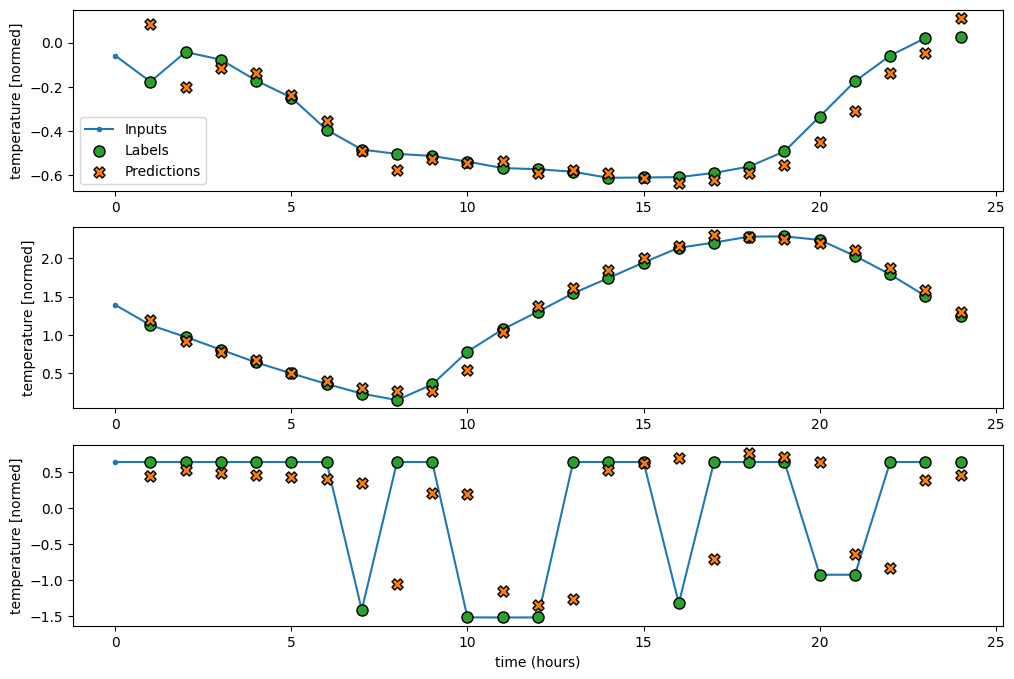

In [127]:
wide_window.plot(lstm_model)

#### residual RNN

In [125]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [126]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        10,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

multi_output_val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
multi_output_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test)

Epoch 1/20
990/990 [==============================] - 13s 10ms/step - loss: 0.1492 - mean_absolute_error: 0.1757 - val_loss: 0.1721 - val_mean_absolute_error: 0.1946
Epoch 2/20
990/990 [==============================] - 17s 17ms/step - loss: 0.1390 - mean_absolute_error: 0.1711 - val_loss: 0.1714 - val_mean_absolute_error: 0.1954
Epoch 3/20
990/990 [==============================] - 11s 11ms/step - loss: 0.1369 - mean_absolute_error: 0.1700 - val_loss: 0.1725 - val_mean_absolute_error: 0.1963
Epoch 4/20
990/990 [==============================] - 9s 9ms/step - loss: 0.1355 - mean_absolute_error: 0.1693 - val_loss: 0.1725 - val_mean_absolute_error: 0.1968
Epoch 5/20
141/141 [==============================] - 1s 7ms/step - loss: 0.1659 - mean_absolute_error: 0.1967


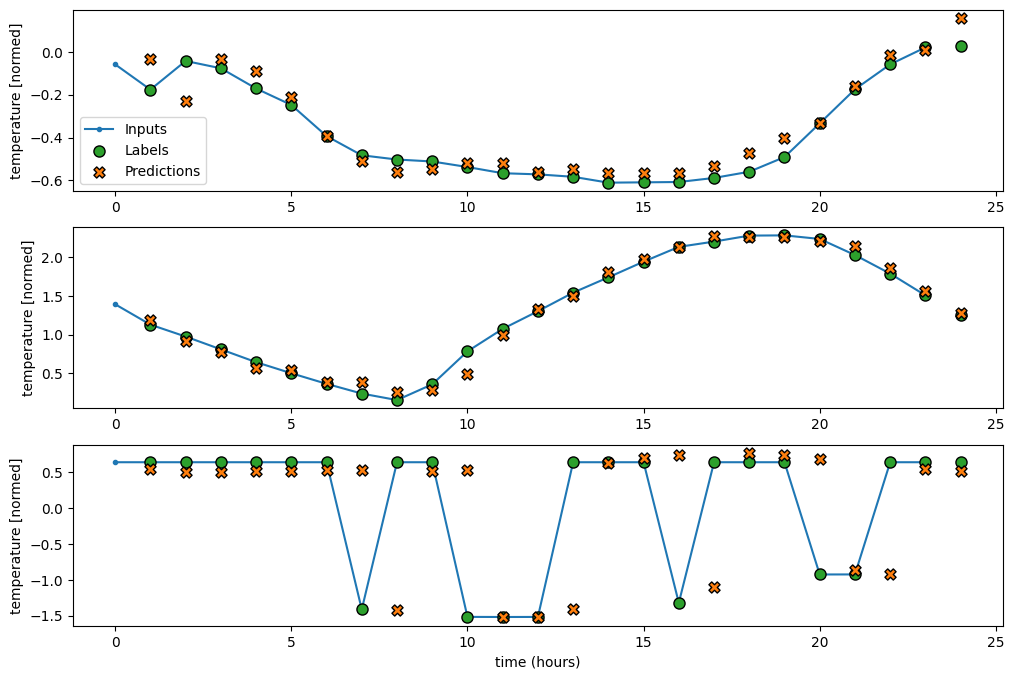

In [128]:
wide_window.plot(residual_lstm)

#### comparing multi-output models

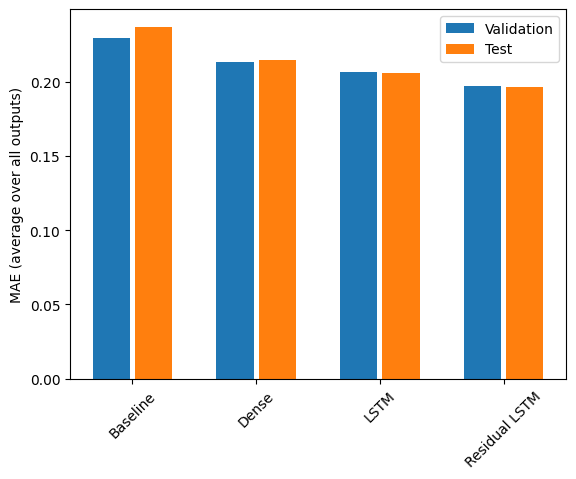

In [129]:
x = np.arange(len(multi_output_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_output_val_performance.values()]
test_mae = [v[metric_index] for v in multi_output_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_output_performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [130]:
for name, value in multi_output_performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.2372
Dense          : 0.2147
LSTM           : 0.2062
Residual LSTM  : 0.1967


## Multi Step Models

prediciting on more than just one hour at a time.

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

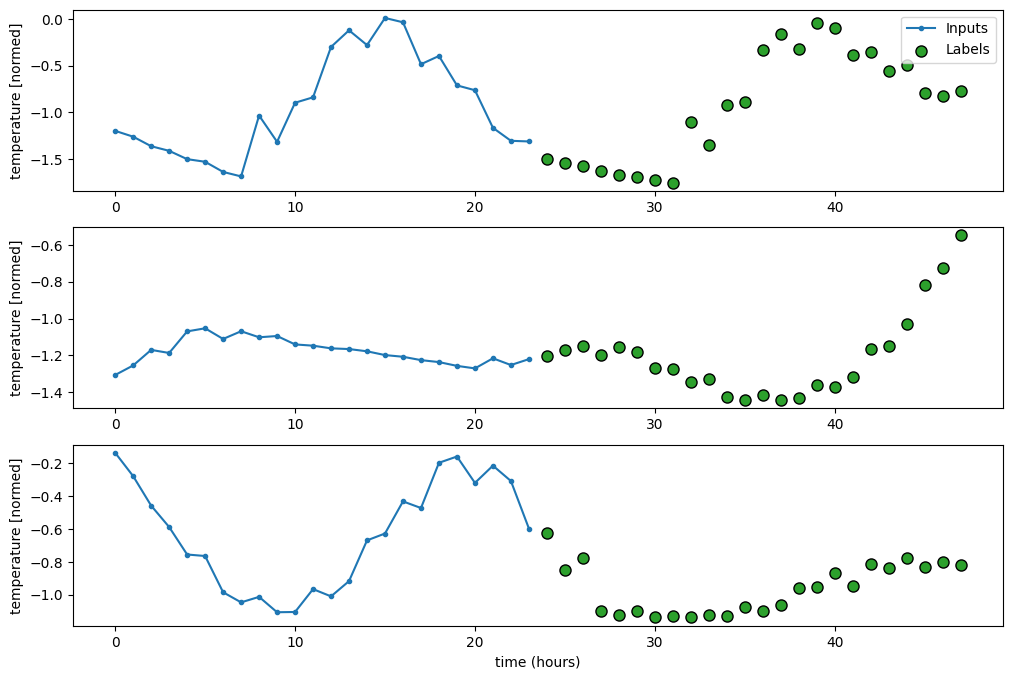

In [131]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### baseline

282/282 [==============================] - 1s 4ms/step - loss: 0.9920 - mean_absolute_error: 0.6342


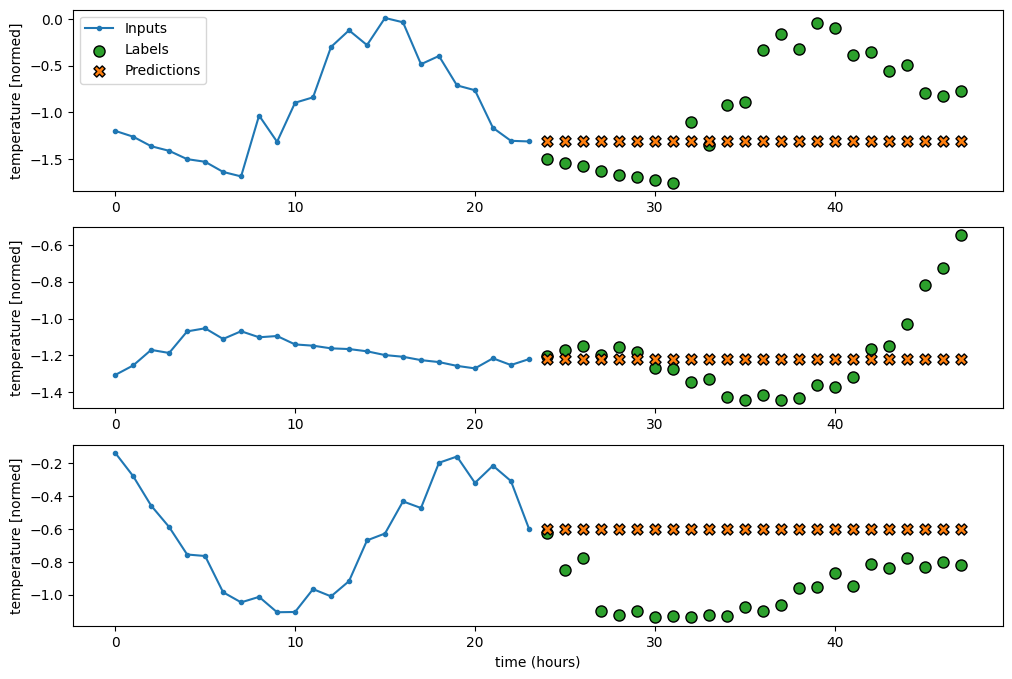

In [132]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

multi_baseline = MultiStepLastBaseline()
multi_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_step_val_performance = {}
multi_step_performance = {}

multi_step_val_performance['Multi Baseline'] = multi_baseline.evaluate(multi_window.val)
multi_step_performance['Multi Baseline'] = multi_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_baseline)

282/282 [==============================] - 1s 4ms/step - loss: 0.6125 - mean_absolute_error: 0.4146


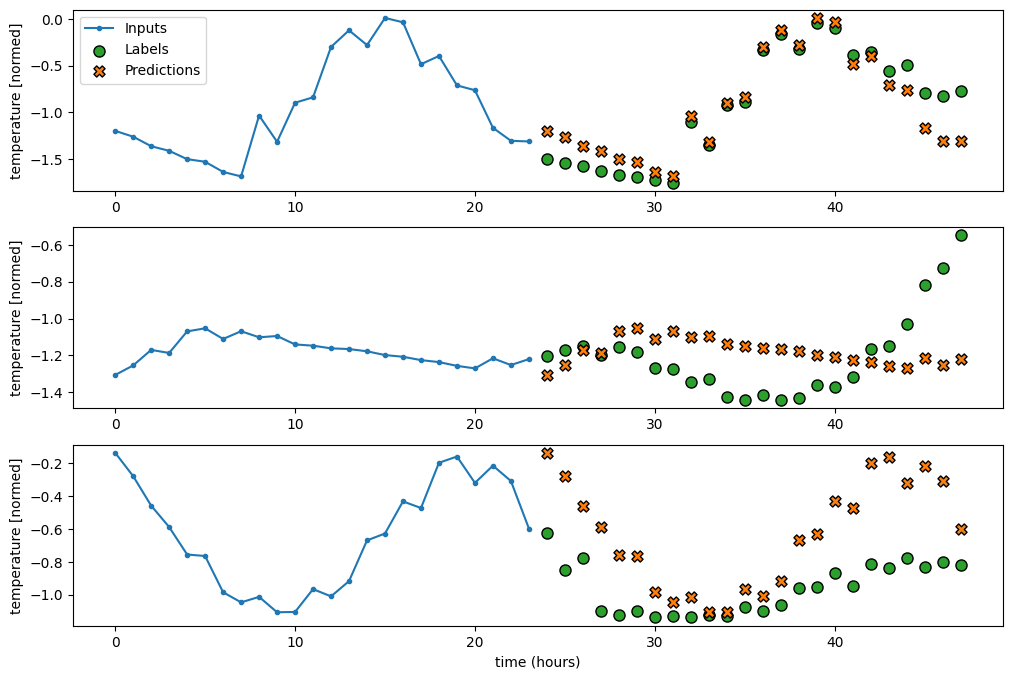

In [133]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_step_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_step_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### single-shot models

#### linear

Epoch 1/20
989/989 [==============================] - 7s 6ms/step - loss: 0.4993 - mean_absolute_error: 0.5293 - val_loss: 0.3897 - val_mean_absolute_error: 0.4175
Epoch 2/20
989/989 [==============================] - 6s 6ms/step - loss: 0.3274 - mean_absolute_error: 0.3538 - val_loss: 0.3511 - val_mean_absolute_error: 0.3427
Epoch 3/20
989/989 [==============================] - 8s 8ms/step - loss: 0.3176 - mean_absolute_error: 0.3164 - val_loss: 0.3486 - val_mean_absolute_error: 0.3263
Epoch 4/20
989/989 [==============================] - 6s 6ms/step - loss: 0.3170 - mean_absolute_error: 0.3090 - val_loss: 0.3483 - val_mean_absolute_error: 0.3237
Epoch 5/20
989/989 [==============================] - 6s 6ms/step - loss: 0.3170 - mean_absolute_error: 0.3080 - val_loss: 0.3483 - val_mean_absolute_error: 0.3234
Epoch 6/20
989/989 [==============================] - 7s 7ms/step - loss: 0.3170 - mean_absolute_error: 0.3079 - val_loss: 0.3484 - val_mean_absolute_error: 0.3235
Epoch 7/20
989/9

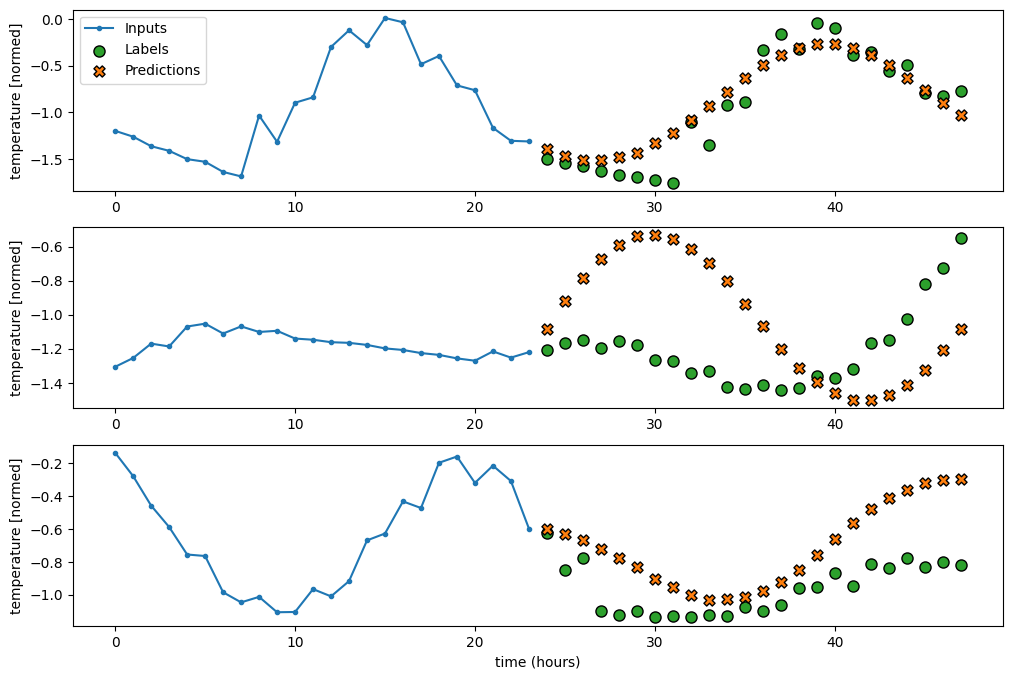

In [134]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*10,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 10])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_step_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_step_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### dense

Epoch 1/20
989/989 [==============================] - 10s 9ms/step - loss: 0.3144 - mean_absolute_error: 0.3198 - val_loss: 0.3388 - val_mean_absolute_error: 0.3247
Epoch 2/20
989/989 [==============================] - 7s 7ms/step - loss: 0.2925 - mean_absolute_error: 0.2973 - val_loss: 0.3425 - val_mean_absolute_error: 0.3260
Epoch 3/20
989/989 [==============================] - 8s 8ms/step - loss: 0.2898 - mean_absolute_error: 0.2954 - val_loss: 0.3396 - val_mean_absolute_error: 0.3245
Epoch 4/20
989/989 [==============================] - 8s 8ms/step - loss: 0.2874 - mean_absolute_error: 0.2939 - val_loss: 0.3388 - val_mean_absolute_error: 0.3239
Epoch 5/20
989/989 [==============================] - 7s 7ms/step - loss: 0.2851 - mean_absolute_error: 0.2925 - val_loss: 0.3381 - val_mean_absolute_error: 0.3229
Epoch 6/20
989/989 [==============================] - 8s 8ms/step - loss: 0.2831 - mean_absolute_error: 0.2913 - val_loss: 0.3380 - val_mean_absolute_error: 0.3235
Epoch 7/20
989/

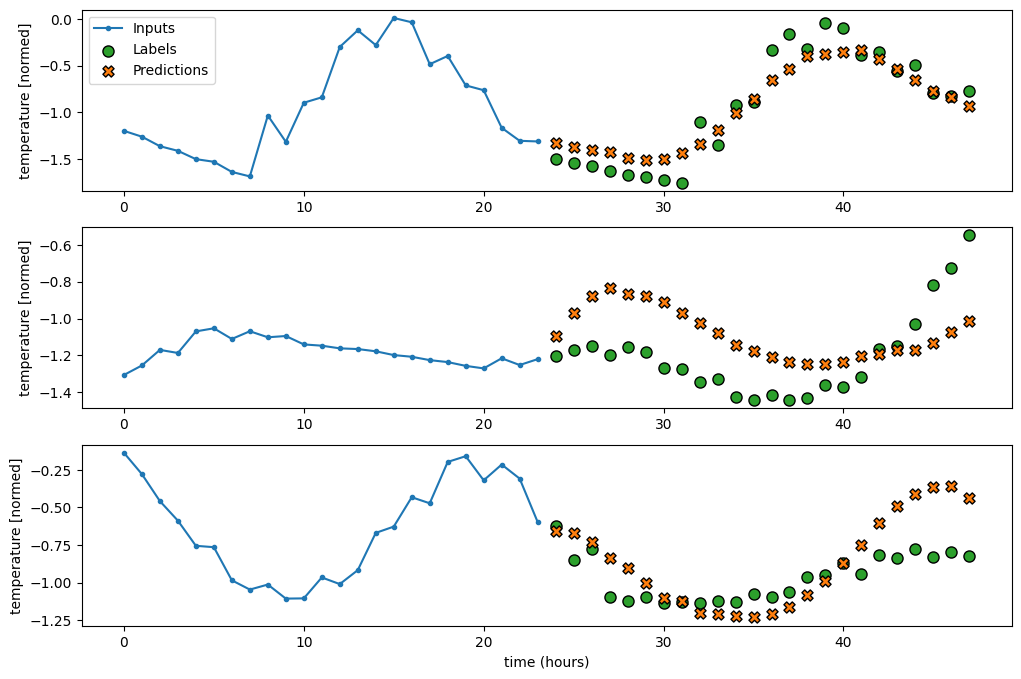

In [135]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*10,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 10])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_step_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_step_performance['Dense'] = multi_dense_model.evaluate(multi_window.test)
multi_window.plot(multi_dense_model)

#### conv1D

Epoch 1/20
989/989 [==============================] - 10s 9ms/step - loss: 0.3122 - mean_absolute_error: 0.3226 - val_loss: 0.3445 - val_mean_absolute_error: 0.3309
Epoch 2/20
989/989 [==============================] - 7s 7ms/step - loss: 0.2868 - mean_absolute_error: 0.2969 - val_loss: 0.3437 - val_mean_absolute_error: 0.3286
Epoch 3/20
989/989 [==============================] - 7s 7ms/step - loss: 0.2842 - mean_absolute_error: 0.2953 - val_loss: 0.3420 - val_mean_absolute_error: 0.3284
Epoch 4/20
989/989 [==============================] - 8s 8ms/step - loss: 0.2825 - mean_absolute_error: 0.2943 - val_loss: 0.3425 - val_mean_absolute_error: 0.3276
Epoch 5/20
989/989 [==============================] - 7s 7ms/step - loss: 0.2808 - mean_absolute_error: 0.2933 - val_loss: 0.3408 - val_mean_absolute_error: 0.3292
Epoch 6/20
989/989 [==============================] - 8s 8ms/step - loss: 0.2793 - mean_absolute_error: 0.2925 - val_loss: 0.3426 - val_mean_absolute_error: 0.3277
Epoch 7/20
989/

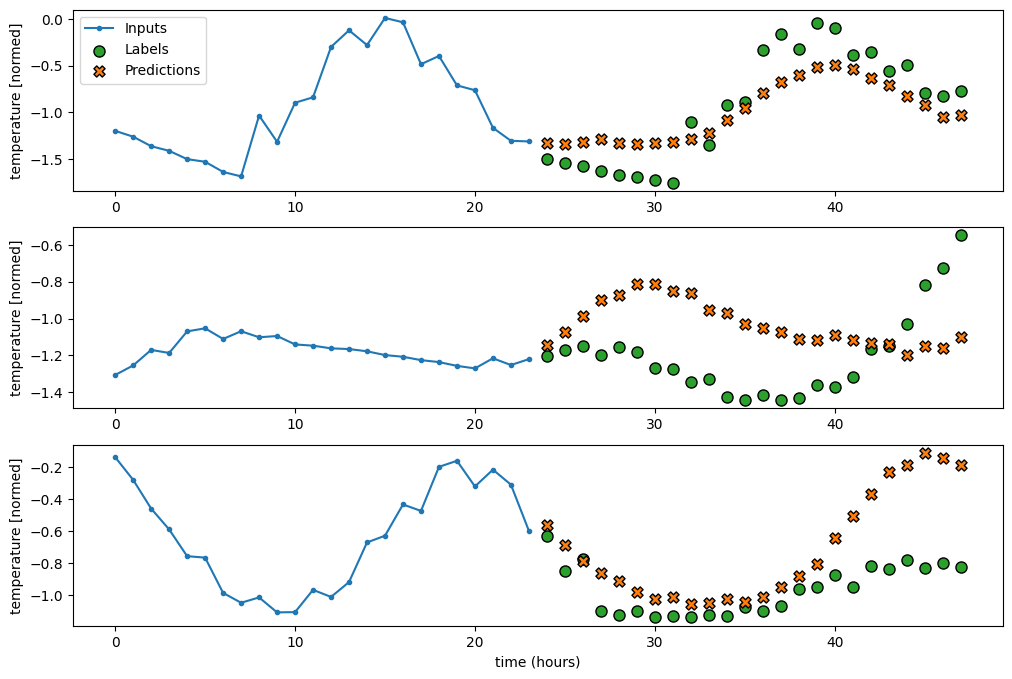

In [136]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*10,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 10])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_step_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_step_performance['Conv'] = multi_conv_model.evaluate(multi_window.test)
multi_window.plot(multi_conv_model)

#### RNN (lstm)

Epoch 1/20
989/989 [==============================] - 12s 10ms/step - loss: 0.3865 - mean_absolute_error: 0.4099 - val_loss: 0.3574 - val_mean_absolute_error: 0.3675
Epoch 2/20
989/989 [==============================] - 8s 8ms/step - loss: 0.2909 - mean_absolute_error: 0.3190 - val_loss: 0.3437 - val_mean_absolute_error: 0.3485
Epoch 3/20
989/989 [==============================] - 9s 9ms/step - loss: 0.2828 - mean_absolute_error: 0.3081 - val_loss: 0.3415 - val_mean_absolute_error: 0.3436
Epoch 4/20
989/989 [==============================] - 11s 11ms/step - loss: 0.2783 - mean_absolute_error: 0.3034 - val_loss: 0.3407 - val_mean_absolute_error: 0.3415
Epoch 5/20
989/989 [==============================] - 10s 10ms/step - loss: 0.2749 - mean_absolute_error: 0.3005 - val_loss: 0.3405 - val_mean_absolute_error: 0.3408
Epoch 6/20
989/989 [==============================] - 8s 8ms/step - loss: 0.2719 - mean_absolute_error: 0.2984 - val_loss: 0.3409 - val_mean_absolute_error: 0.3411
Epoch 7/20

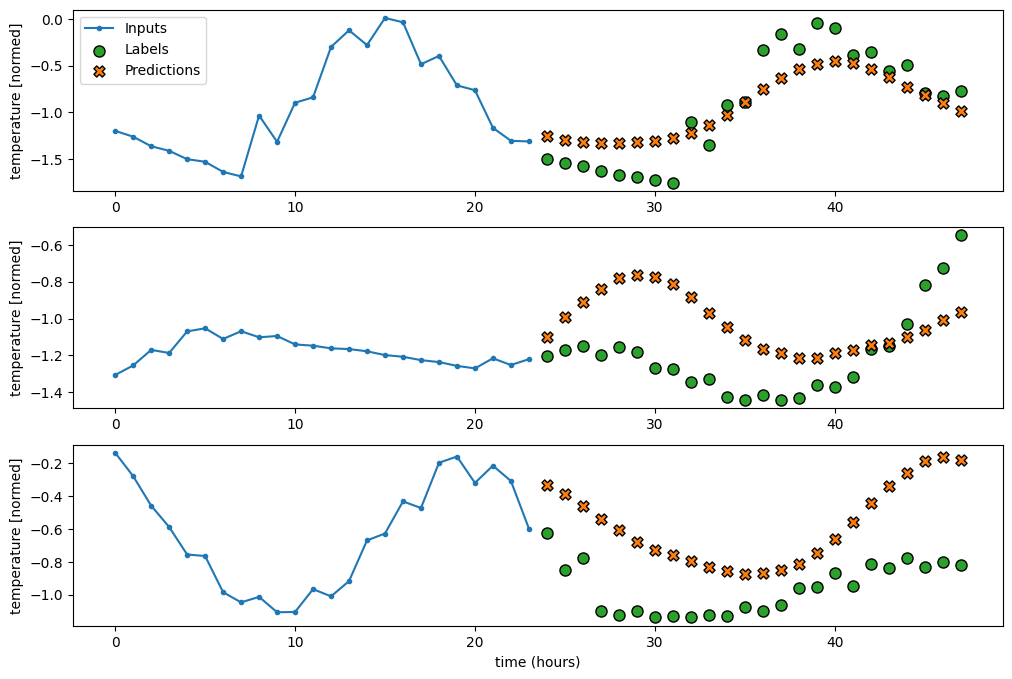

In [137]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*10,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 10])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_step_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_step_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test)
multi_window.plot(multi_lstm_model)

#### auto regressive RNN

In [138]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(10)

In [139]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [140]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [141]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 10])

In [142]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [143]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 10)


Epoch 1/20
989/989 [==============================] - 65s 60ms/step - loss: 0.3823 - mean_absolute_error: 0.4070 - val_loss: 0.3874 - val_mean_absolute_error: 0.3894
Epoch 2/20
989/989 [==============================] - 59s 60ms/step - loss: 0.3005 - mean_absolute_error: 0.3360 - val_loss: 0.3635 - val_mean_absolute_error: 0.3697
Epoch 3/20
989/989 [==============================] - 62s 62ms/step - loss: 0.2895 - mean_absolute_error: 0.3230 - val_loss: 0.3540 - val_mean_absolute_error: 0.3616
Epoch 4/20
989/989 [==============================] - 59s 59ms/step - loss: 0.2841 - mean_absolute_error: 0.3169 - val_loss: 0.3557 - val_mean_absolute_error: 0.3615
Epoch 5/20
989/989 [==============================] - 58s 59ms/step - loss: 0.2804 - mean_absolute_error: 0.3132 - val_loss: 0.3501 - val_mean_absolute_error: 0.3541
Epoch 6/20
989/989 [==============================] - 59s 60ms/step - loss: 0.2773 - mean_absolute_error: 0.3106 - val_loss: 0.3520 - val_mean_absolute_error: 0.3539
Epoc

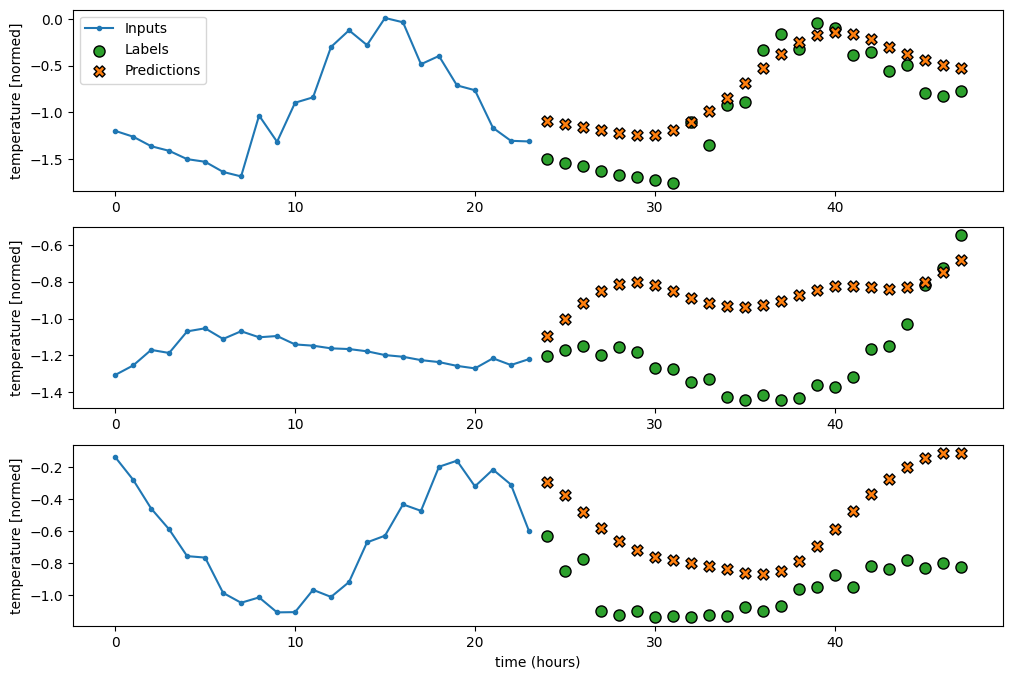

In [144]:
history = compile_and_fit(feedback_model, multi_window)

multi_step_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_step_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test)
multi_window.plot(feedback_model)

#### comparing multi-step models

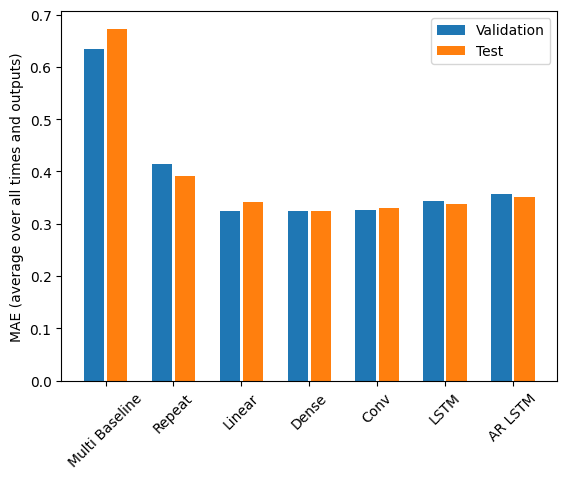

In [145]:
x = np.arange(len(multi_step_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_step_val_performance.values()]
test_mae = [v[metric_index] for v in multi_step_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_step_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [146]:
for name, value in multi_step_performance.items():
  print(f'{name:10s}: {value[1]:0.4f}')

Multi Baseline: 0.6732
Repeat    : 0.3908
Linear    : 0.3409
Dense     : 0.3240
Conv      : 0.3297
LSTM      : 0.3387
AR LSTM   : 0.3511
